# Indicadores de Dominância na F1

  <!-- novo -->
  
  Na história da Formula 1, de tempos em tempos, ocorrem dominações (vários títulos conquistados em seguida). Geralmente (mas nem sempre) essas dominações acontecem quando um novo regulamento técnico entra em vigor. Esse é o caso da Mercedes (2014-presente), é semelhante ao caso da Red Bull (2010-2013), que apesar de não ter dominado no ano em que o novo regulamento entrou em vigor (que foi dominado por uma equipe que não existia nos anos anteriores), cresceu muito com esse novo regulamento e no ano seguinte foi campeã.  
  
  E uma hipótese que levantei é a de que em anos anteriores (mais especificamente **no ano anterior**) já era possível ver certos indicadores dessa possível dominância. Esses indicadores podem ser um aumento significativo no número de vitórias, um aumento significativo no número de poles, um aumento significativo no número médio de pontos por corrida.  
  
  Neste notebook serão analisadas 3 dominações: Ferrari de 1999 a 2004, Red Bull de 2010 a 2013 e Mercedes de 2014 até o presente (escrito em 2020).  
  
  Várias medidas serão utilizadas, como a posição na Tabela de Construtores, Número de Vitórias, Número de Pole Positions, Número Médio de Pontos por Corrida, o       Desvio Padrão da Pontuação, Média Alta dos Pontos (conceito inventado por mim, consiste na média dos valores que estão acima da média de pontos) e Média Baixa (conceito inventado por mim, consiste na média dos valores que estão abaixo da média de pontos). Esses dois conceitos serão utilizados juntamente com a média geral, para que se possa ter uma noção da constância da equipe na temporada.  
  
  Logo, o foco está principalmente no ano anterior a dominação, porém a dominação também será descrita. Então, se o presente estudante de Ciência dos Dados achar que algum ano qualquer é interessante de ser analisado (sem ser necessariamente o ano anterior a dominação), esse ano será analisado. 

---
## Importando os dados

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
!pip install seaborn==0.11.0
import seaborn as sns
plt.rc('figure', figsize = (15, 8))
sns.set_style('whitegrid')

In [2]:
resultados_dos_construtores = pd.read_csv('Dados F1/constructor_results.csv')
tabela_dos_construtores = pd.read_csv('Dados F1/constructor_standings.csv')
construtores = pd.read_csv('Dados F1/constructors.csv')
corridas = pd.read_csv('Dados F1/races.csv')
qualificacao = pd.read_csv('Dados F1/qualifying.csv')

In [3]:
qualificacao = qualificacao.loc[:, ['raceId', 'position', 'constructorId']]
poles = qualificacao[qualificacao.position == 1]
poles.head()

,raceId,position,constructorId
0,18,1,1
22,19,1,6
44,20,1,2
66,21,1,6
88,22,1,6


In [4]:
resultados_dos_construtores.head()

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N


In [5]:
corridas.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [6]:
construtores = construtores[['constructorId', 'name']]
construtores.rename(columns = {'name': 'team_name'}, inplace = True)
construtores.head()

,constructorId,team_name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso


In [7]:
tabela_dos_construtores.head()

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [8]:
none = None
nonetype = type(none)

---
## Definindo Funções

In [9]:
def grafico(y, dataset, ylabel, titulo, paleta):
    ax = sns.barplot(x = 'team_name', y = y, data = dataset, palette = paleta, edgecolor = 'black', linewidth = 1)
    ax.set_xlabel('Equipe', fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.set_title(titulo, loc = 'left', fontsize = 18)
    ax = ax
    return ax

In [10]:
def grafico_comparacao(y, dataset_principal, dataset_secundario, paleta, titulo, ylabel, cor):
    ax = sns.lineplot(x = 'year', y = y, data = dataset_principal, marker = 'o', markersize = 12, 
                                linewidth = 6, color = cor)
    sns.scatterplot(x = 'year', y = y, hue = 'Nome da Equipe', data = dataset_secundario, s = 300, palette = paleta)
    ax.set_title(titulo, loc = 'left', fontsize = 18)
    xticks = list(dataset_principal.year)
    ax.set_xticks(xticks)
    ax.set_xlabel('Ano', fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax = ax
    return ax

In [11]:
def grafico_comparacao_pontos(dataset_principal, dataset_secundario, paleta, titulo, cor):
    ax = sns.lineplot(x = 'year', y = 'points_per_race', data = dataset_principal, marker = 'o', markersize = 12, 
                                linewidth = 6, color = cor)
    sns.lineplot(x = 'year', y = 'higher_medium', data = dataset_principal, color = cor, marker = 'o')
    sns.lineplot(x = 'year', y = 'lower_medium', data = dataset_principal, color = cor, marker = 'o')
    sns.scatterplot(x = 'year', y = 'points_per_race', hue = 'Nome da Equipe',  data = dataset_secundario, s = 300, palette = paleta)
    sns.scatterplot(x = 'year', y = 'higher_medium', hue = 'Nome da Equipe', data = dataset_secundario, s = 100, palette = paleta, legend = False)
    sns.scatterplot(x = 'year', y = 'lower_medium', hue = 'Nome da Equipe', data = dataset_secundario, s = 100, palette = paleta, legend = False)
    xticks = list(dataset_principal.year)
    ax.set_xticks(xticks)
    ax.set_title(titulo, loc = 'left', fontsize = 15)
    ax.set_xlabel('Ano', fontsize = 12)
    ax.set_ylabel('Pontos por Corrida', fontsize = 12)
    ax = ax
    return ax

In [12]:
def grafico_evolucao_pontuacao(dataset_principal, dataset_secundario, cor_equipe, cor_rival, titulo):
    ax = sns.lineplot(x = dataset_principal['round'], y = 'points', data = dataset_principal, color = cor_equipe, label = dataset_principal.loc[0, 'team_name'],
                     marker = 'o', linewidth = 4, markersize = 8)
    sns.lineplot(x = dataset_secundario['round'], y = 'points', data = dataset_secundario, color = cor_rival, label = dataset_secundario.loc[0, 'team_name'],
                marker = 'o', linewidth = 4, markersize = 8)
    ax.set_title(titulo, loc = 'left', fontsize = 18)
    xticks = list(dataset_principal['round'])
    labels = list(dataset_principal.name)
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels, rotation = 45, ha = 'right', rotation_mode = 'anchor')
    ax.set_xlabel('Rodada', fontsize = 12)
    ax.set_ylabel('Pontos', fontsize = 12)
    ax = ax
    return ax

In [13]:
def grafico_posicao(y, dataset, titulo, ylabel, cor):
    ax = sns.lineplot(x = 'year', y = y, data = dataset, marker = 'o', markersize = 12, linewidth = 6, color = cor)
    ax.invert_yaxis()
    xticks = list(dataset.year)
    ax.set_xticks(xticks)
    ax.set_title(titulo, loc = 'left', fontsize = 18)
    ax.set_xlabel('Ano', fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax = ax
    return ax

In [14]:
def seleciona_pontuacao(ano_analisado, equipe_analisada, equipe_periodo, rivais_equipe, converter_pontuacao = False):
    ano = corridas[corridas.year == ano_analisado]
    ano = ano.loc[:,['year', 'round', 'circuitId', 'name', 'raceId']]
    resultados_ano = ano.set_index('raceId').join(tabela_dos_construtores.set_index('raceId'))
    del resultados_ano['constructorStandingsId']
    del resultados_ano['positionText']
    construtores_ano = construtores[construtores.constructorId.isin(resultados_ano.constructorId)]
    resultados_ano = resultados_ano.set_index('constructorId').join(construtores_ano.set_index('constructorId'))
    resultados_ano.index = range(resultados_ano.shape[0])
    if converter_pontuacao and resultados_ano.loc[0, 'year'] < 2010:
        resultados_ano.points = resultados_ano.points * 2.5
    resultados_ano.sort_values(by = ['round', 'position'], inplace = True)
    final_ano = resultados_ano.query('round == round.max()')
    final_ano_c = final_ano.copy()
    final_ano_c['points_per_race'] = final_ano.points / final_ano['round']
    final_ano_c.sort_values(by = 'position', inplace = True)
    final_ano_c.index = range(final_ano_c.shape[0])

    resultados_ano_equipe = resultados_ano[resultados_ano.team_name == equipe_analisada]
    resultados_ano_equipe.index = range(resultados_ano_equipe.shape[0])
    copia_resultados = resultados_ano_equipe.copy()
    copia_resultados['points_in_each_race'] = resultados_ano_equipe.points.diff()
    copia_resultados.index = range(resultados_ano_equipe.shape[0])
    copia_resultados.fillna(copia_resultados.loc[0, 'points'], inplace = True)

    media_cima = copia_resultados[copia_resultados.points_in_each_race > copia_resultados.points_in_each_race.mean()].points_in_each_race.mean()
    media_baixo = copia_resultados[copia_resultados.points_in_each_race < copia_resultados.points_in_each_race.mean()].points_in_each_race.mean()
        
    auxiliar = final_ano_c[final_ano_c.team_name == equipe_analisada]
    auxiliar2 = auxiliar.copy()
    auxiliar2['higher_medium'] = media_cima
    auxiliar2['lower_medium'] = media_baixo
    auxiliar2['std'] = copia_resultados.points_in_each_race.std()

    if (type(equipe_periodo) == nonetype):
        equipe_periodo = auxiliar2
    else:
        equipe_periodo = pd.concat([equipe_periodo, auxiliar2])
        equipe_periodo.sort_values(by = 'year', inplace = True)

    if equipe_analisada in list(final_ano_c[final_ano_c.points == final_ano_c.points.max()].team_name):
        equipe_rival = final_ano_c.loc[1, 'team_name']
    else:
        equipe_rival = final_ano_c.loc[0, 'team_name']

    resultados_ano_equipe_rival = resultados_ano[resultados_ano.team_name == equipe_rival]
    if list(resultados_ano_equipe_rival['round']) != list(auxiliar2['round']):
        for i in range(1, auxiliar2['round'].max() + 1):
            if i in list(resultados_ano_equipe_rival['round']):
                break
            if i not in list(resultados_ano_equipe_rival['round']):
                generico = {'round': i, 'team_name': resultados_ano_equipe_rival.loc[0, 'team_name'], 
                            'name': resultados_ano_equipe.loc[i - 1, 'name'], 'points': 0}
                df = pd.DataFrame(generico, index = [resultados_ano_equipe_rival['round'].max() + i])
                resultados_ano_equipe_rival = pd.concat([resultados_ano_equipe_rival, df])
                
    copia_resultados_rival = resultados_ano_equipe_rival.sort_values(by = 'round').copy()
    copia_resultados_rival['points_in_each_race'] = resultados_ano_equipe_rival.sort_values(by = 'round').points.diff()
    copia_resultados_rival.index = range(resultados_ano_equipe_rival.shape[0])
    copia_resultados_rival2 = copia_resultados_rival.copy()
    copia_resultados_rival2.fillna(copia_resultados_rival2.loc[0, 'points'], inplace = True)
    selecao_cima = copia_resultados_rival2.points_in_each_race > copia_resultados_rival2.points_in_each_race.mean()
    selecao_baixo = copia_resultados_rival2.points_in_each_race < copia_resultados_rival2.points_in_each_race.mean()
    media_cima_rival2 = copia_resultados_rival2[selecao_cima].points_in_each_race.mean()
    media_baixo_rival2 = copia_resultados_rival2[selecao_baixo].points_in_each_race.mean()
    final_rival = final_ano_c[final_ano_c.team_name == equipe_rival]
    aux = final_rival.copy()
    aux['higher_medium'] = media_cima_rival2
    aux['lower_medium'] = media_baixo_rival2
    aux['std'] = copia_resultados_rival2.points_in_each_race.std()

    if (type(rivais_equipe) == nonetype):
        rivais_equipe = aux
    else:
        rivais_equipe = pd.concat([rivais_equipe, aux])
        rivais_equipe.sort_values(by = 'year', inplace = True)
           
    return final_ano_c, equipe_periodo, rivais_equipe

In [15]:
def resultados_ano(ano_analisado, equipe_analisada, conversao = False):
    ano = corridas[corridas.year == ano_analisado]
    ano.loc[:, ['year', 'round', 'circuitId', 'name', 'raceId']]
    resultados_ano = ano.set_index('raceId').join(tabela_dos_construtores.set_index('raceId'))
    construtores_ano = construtores[construtores.constructorId.isin(resultados_ano.constructorId)]
    resultados_ano = resultados_ano.set_index('constructorId').join(construtores_ano.set_index('constructorId'))
    resultados_ano = resultados_ano.loc[:, ['name', 'year', 'round', 'points', 'position', 'wins', 'team_name']]
    resultados_ano.sort_values(by = ['round', 'position'], inplace = True)
    resultados_ano.index = range(resultados_ano.shape[0])
    if conversao and resultados_ano.loc[0, 'year'] < 2010:
        resultados_ano.points = resultados_ano.points * 2.5
    
    resultados_ano_equipe = resultados_ano[resultados_ano.team_name == equipe_analisada]
    copia_resultados = resultados_ano_equipe.copy()
    copia_resultados['points_in_each_race'] = resultados_ano_equipe.points.diff()
    copia_resultados['mean'] = copia_resultados.points.max() / copia_resultados['round'].max()
    copia_resultados.index = range(resultados_ano_equipe.shape[0])
    copia_resultados.fillna(copia_resultados.loc[0, 'points'], inplace = True)
    
    auxiliar = resultados_ano.query('round == round.max()')
    auxiliar.index = range(auxiliar.shape[0])
    
    if equipe_analisada in list(auxiliar[auxiliar.points == auxiliar.points.max()].team_name):
        equipe_rival = auxiliar.loc[1, 'team_name']
    else:
        equipe_rival = auxiliar.loc[0, 'team_name']
            
    resultados_ano_rival_equipe = resultados_ano[resultados_ano.team_name == equipe_rival]
    resultados_ano_rival_equipe.index = range(resultados_ano_rival_equipe.shape[0])
    if list(resultados_ano_rival_equipe['round']) != list(copia_resultados['round']):
        for i in range(1, copia_resultados['round'].max() + 1):
            if i in list(resultados_ano_rival_equipe['round']):
                break
            if i not in list(resultados_ano_rival_equipe['round']):
                generico = {'round': i, 'team_name': resultados_ano_rival_equipe.loc[0, 'team_name'], 
                            'name': copia_resultados.loc[i - 1, 'name'], 'points': 0}
                df = pd.DataFrame(generico, index = [resultados_ano_rival_equipe['round'].max() + i])
                resultados_ano_rival_equipe = pd.concat([resultados_ano_rival_equipe, df])
            
     
    copia_resultados_rival = resultados_ano_rival_equipe.sort_values(by = 'round').copy() 
    copia_resultados_rival['points_in_each_race'] = resultados_ano_rival_equipe.sort_values(by = 'round').points.diff()
    copia_resultados_rival['mean'] = copia_resultados_rival.points.max() / copia_resultados_rival['round'].max()
    copia_resultados_rival.index = range(copia_resultados_rival.shape[0])
    copia_resultados_rival.fillna(copia_resultados_rival.loc[0, 'points'], inplace = True)
    
    return copia_resultados, copia_resultados_rival

In [16]:
def filtra_pole(ano_analisado, poles_equipe, poles_rival, equipe_analisada):
    
    poles_0 = {'team_name': equipe_analisada, 'poles_count': [0]}
    poles_0 = pd.DataFrame(poles_0)

    ano = corridas[corridas.year == ano_analisado]
    ano = ano.loc[:,['year', 'round', 'circuitId', 'name', 'raceId']]
    resultados_ano = ano.set_index('raceId').join(tabela_dos_construtores.set_index('raceId'))
    construtores_ano = construtores[construtores.constructorId.isin(resultados_ano.constructorId)]
    selecao_poles = poles.raceId.isin(resultados_ano.index)
    poles_ano = poles[selecao_poles].set_index('constructorId').join(construtores_ano.set_index('constructorId'))
    poles_ano.rename(columns = {'position': 'poles_count'}, inplace = True)
    poles_ano = poles_ano.groupby(by = 'team_name', as_index = False).count()
    del poles_ano['raceId']
    poles_ano.sort_values(by = 'poles_count', inplace = True, ascending = False)
    poles_ano.index = range(poles_ano.shape[0])

    if (type(poles_equipe) == nonetype):
        if equipe_analisada in list(poles_ano.team_name):
            poles_equipe = poles_ano[poles_ano.team_name == equipe_analisada]
        else:
            poles_equipe = poles_0
    else:
        if equipe_analisada in list(poles_ano.team_name):
            poles_equipe = pd.concat([poles_equipe, poles_ano[poles_ano.team_name == equipe_analisada]])
        else:
            poles_equipe = pd.concat([poles_equipe, poles_0])
        
    if (type(poles_rival) == nonetype):
        if (poles_ano.loc[0, 'team_name'] == equipe_analisada):
            poles_rival = poles_ano.query('index == 1')
        else:
            poles_rival = poles_ano.query('index == 0')
    else:
        if (poles_ano.loc[0, 'team_name'] == equipe_analisada):
            poles_rival = pd.concat([poles_rival, poles_ano.query('index == 1')])
        else:
            poles_rival = pd.concat([poles_rival, poles_ano.query('index == 0')])
        
    return poles_ano, poles_equipe, poles_rival

---

## <font color=MidnightBlue>Analisando a Dominância da Red Bull Racing (2010-2013)

<!--novo--><p>Começaremos com a dominância de 4 anos da Red Bull Racing, de 2010 a 2013, compararemos suas vitórias, seus pontos, a mudança de seu desempenho ao longo dos anos anteriores (e também com outras dominâncias) para descobrir se há ou não algum tipo de indicador que a dominância pode ocorrer.
Dominâncias são difíceis de serem quebradas, mas um dos grandes "empurrões" para uma nova dominância é uma mudança de regulamento técnico. O Regulamento Aerodinâmico mudou de 2008 para 2009, e o ano de 2009 foi dominado pela Brawn GP, uma equipe inexistente do grid até então (até por isso ela não será analisada).</p>
A Red Bull será analisada desde seu começo, em 2005, até o ano em que ela não foi mais dominante, no caso, 2014.

In [17]:
poles_rbr = None
rival_poles_rbr = None
rbr_05_14 = None
rival_rbr = None

### 2005 a 2009

In [18]:
final_rbr_2005, rbr_05_14, rival_rbr = seleciona_pontuacao(2005, 'Red Bull', rbr_05_14, rival_rbr, True)
poles_2005, poles_rbr, rival_poles_rbr = filtra_pole(2005, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2005, resultados_rival_rbr_2005 = resultados_ano(2005, 'Red Bull', True)

In [19]:
final_rbr_2006, rbr_05_14, rival_rbr = seleciona_pontuacao(2006, "Red Bull", rbr_05_14, rival_rbr, True)
poles_2006, poles_rbr, rival_poles_rbr = filtra_pole(2006, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2006, resultados_rival_rbr_2006 = resultados_ano(2006, 'Red Bull', True)

In [20]:
final_rbr_2007, rbr_05_14, rival_rbr = seleciona_pontuacao(2007, "Red Bull", rbr_05_14, rival_rbr, True)
poles_2007, poles_rbr, rival_poles_rbr = filtra_pole(2007, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2007, resultados_rival_rbr_2007 = resultados_ano(2007, 'Red Bull', True)

In [21]:
final_rbr_2008, rbr_05_14, rival_rbr = seleciona_pontuacao(2008, "Red Bull", rbr_05_14, rival_rbr, True)
poles_2008, poles_rbr, rival_poles_rbr = filtra_pole(2008, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2008, resultados_rival_rbr_2008 = resultados_ano(2008, 'Red Bull', True)

In [22]:
final_rbr_2009, rbr_05_14, rival_rbr = seleciona_pontuacao(2009, "Red Bull", rbr_05_14, rival_rbr, True)
poles_2009, poles_rbr, rival_poles_rbr = filtra_pole(2009, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2009, resultados_rival_rbr_2009 = resultados_ano(2009, 'Red Bull', True)

#### Traçando os Gráficos de 2009

##### Pontos de cada equipe em 2009

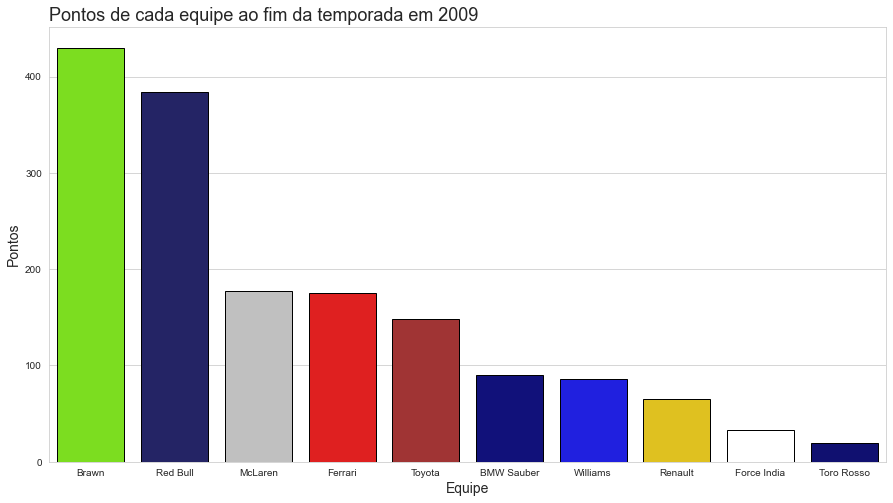

In [23]:
paleta = {'Red Bull': 'midnightblue', 'Brawn': 'lawngreen', 'McLaren': 'silver', 'Ferrari': 'red', 'Toyota': 'firebrick', 'BMW Sauber': 'darkblue',
         'Williams': 'blue', 'Renault': 'gold', 'Force India': 'white', 'Toro Rosso': 'navy'}
pontos_2009 = grafico('points', final_rbr_2009, 'Pontos',
                 'Pontos de cada equipe ao fim da temporada em 2009', paleta)

##### Vitórias de cada equipe em 2009

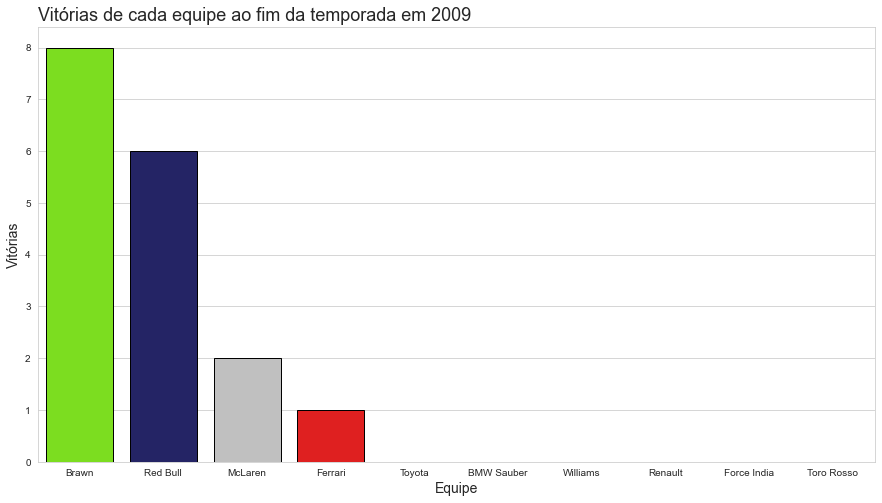

In [24]:
vitorias_2009 = grafico('wins', final_rbr_2009, 'Vitórias', 
       'Vitórias de cada equipe ao fim da temporada em 2009', paleta)

##### Poles de cada equipe em 2009

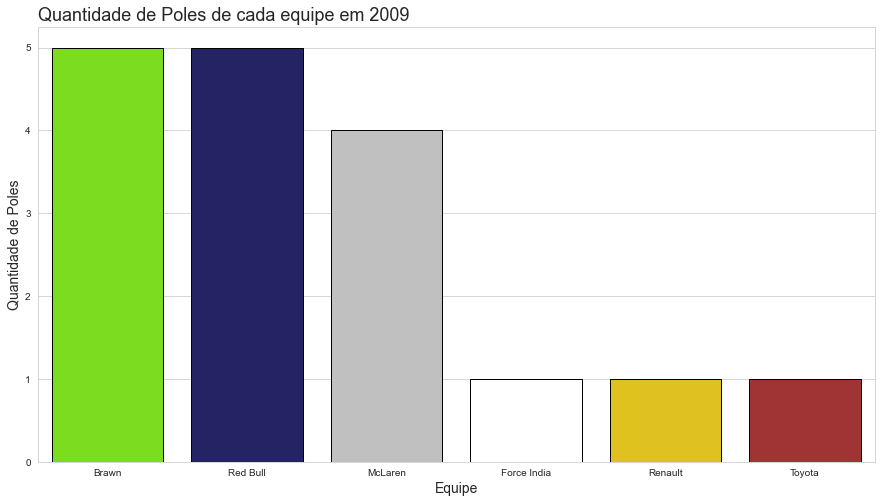

In [25]:
pole_positions_2009 = grafico('poles_count', poles_2009, 
                              'Quantidade de Poles', 'Quantidade de Poles de cada equipe em 2009', paleta)

#### Análise de 2009

<!--novo-->2009 foi um ano produtivo para a Red Bull, ela teve uma pontuação levemente menor que a Brawn GP teve, mas teve o mesmo número de Pole Positions e duas vitórias a menos, algo muito diferente dos anos anteriores da Red Bull, onde um simples pódio já era um ótimo resultado.

### Descrevendo o ano de 2010 da Red Bull

In [26]:
final_rbr_2010, rbr_05_14, rival_rbr = seleciona_pontuacao(2010, 'Red Bull', rbr_05_14, rival_rbr)
poles_2010, poles_rbr, rival_poles_rbr = filtra_pole(2010, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2010, resultados_rival_rbr_2010 = resultados_ano(2010, 'Red Bull')

#### Traçando os gráficos de 2010

##### Pontos de cada equipe em 2010

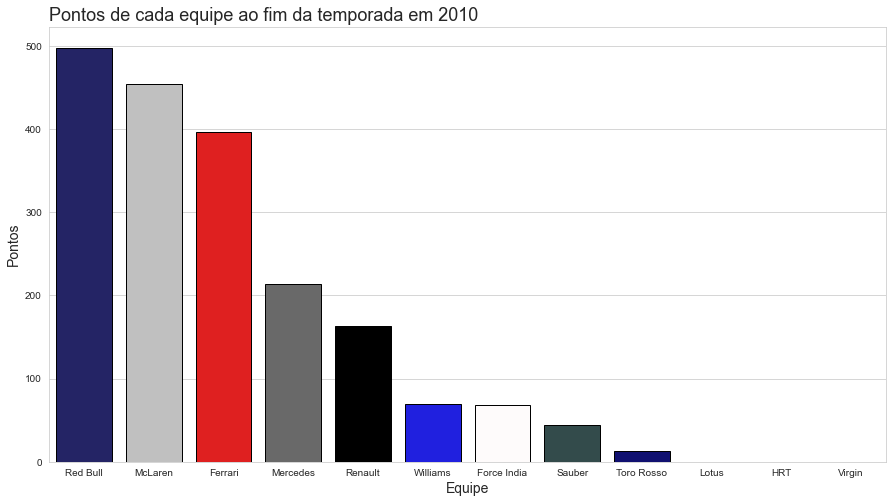

In [27]:
paleta = {'Red Bull': 'midnightblue', 'McLaren': 'silver', 'Ferrari': 'red', 'Toyota': 'firebrick', 'Williams': 'blue', 'Renault': 'black', 
          'Force India': 'snow', 'Toro Rosso': 'navy', 'Mercedes': 'dimgray', 'Sauber': 'darkslategrey', 'Lotus': 'darkgreen', 'HRT': 'darkslategray', 
          'Virgin': 'darkred'}
pontos_2010 = grafico('points', final_rbr_2010, 'Pontos', 
       'Pontos de cada equipe ao fim da temporada em 2010', paleta)

##### Vitórias de cada equipe em 2010

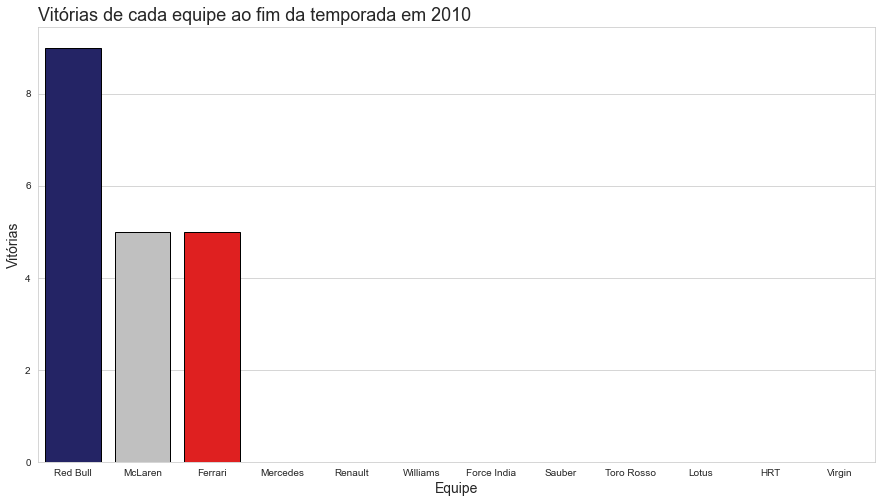

In [28]:
vitorias_2010 = grafico('wins', final_rbr_2010, 'Vitórias', 
       'Vitórias de cada equipe ao fim da temporada em 2010', paleta)

##### Quantidade de poles de cada equipe em 2010

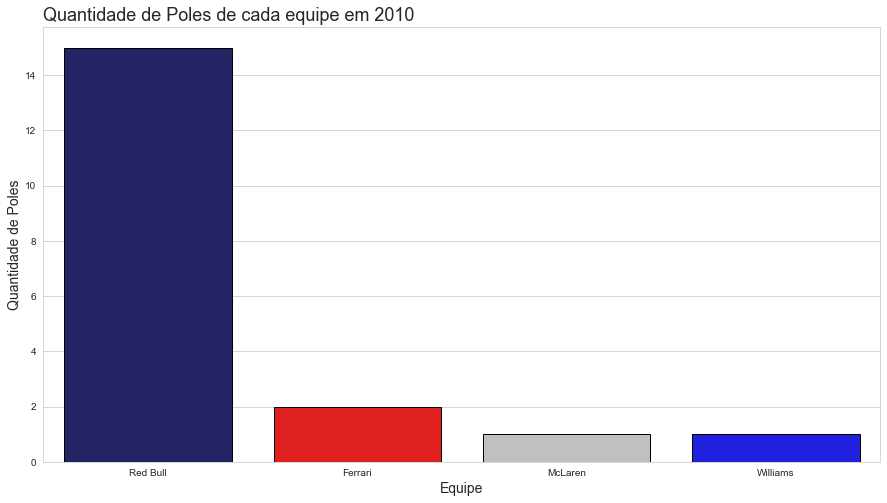

In [29]:
pole_positions_2010 = grafico('poles_count', poles_2010, 
                              'Quantidade de Poles', 'Quantidade de Poles de cada equipe em 2010', paleta)

#### Análise de 2010

<!-- novo --><p>2010 foi o ano do primeiro Título de Construtores da Red Bull. Em 2009, houve uma mudança de regulamento que mudou a aerodinâmica dos carros, e por conta disso, foi um ano atípico, onde uma equipe que nunca havia existido anteriormente (Brawn GP) ganhou o título por uma série de motivos aos quais não serão discutidos aqui.</p><p> Porém, no ano seguinte, que a Brawn GP foi vendida para a Mercedes e que algumas inovações trazidas pela Brawn foram implantadas por algumas equipes, a Red Bull se sobressaiu. 2009 foi um ótimo ano para a Red Bull, foi vice-campeã, ganhou muitas corridas, conquistou muitos pontos e 2010 foi melhor ainda, sendo campeã de construtores com uma corrida de antecedência e teve seu piloto campeão. É um contraste muito grande com seus anos anterioes, onde a equipe não se destacava muito.</p>

### 2011 a 2014

In [30]:
final_rbr_2011, rbr_05_14, rival_rbr = seleciona_pontuacao(2011, 'Red Bull', rbr_05_14, rival_rbr)
poles_2011, poles_rbr, rival_poles_rbr = filtra_pole(2011, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2011, resultados_rival_rbr_2011 = resultados_ano(2011, 'Red Bull')

In [31]:
final_rbr_2012, rbr_05_14, rival_rbr = seleciona_pontuacao(2012, 'Red Bull', rbr_05_14, rival_rbr)
poles_2012, poles_rbr, rival_poles_rbr = filtra_pole(2012, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2012, resultados_rival_rbr_2012 = resultados_ano(2012, 'Red Bull')

In [32]:
final_rbr_2013, rbr_05_14, rival_rbr = seleciona_pontuacao(2013, 'Red Bull', rbr_05_14, rival_rbr)
poles_2013, poles_rbr, rival_poles_rbr = filtra_pole(2013, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2013, resultados_rival_rbr_2013 = resultados_ano(2013, 'Red Bull')

In [33]:
final_rbr_2014, rbr_05_14, rival_rbr = seleciona_pontuacao(2014, 'Red Bull', rbr_05_14, rival_rbr)
poles_2014, poles_rbr, rival_poles_rbr = filtra_pole(2014, poles_rbr, rival_poles_rbr, 'Red Bull')
resultados_rbr_2014, resultados_rival_rbr_2014 = resultados_ano(2014, 'Red Bull')

In [34]:
rival_rbr.rename(columns = {'team_name' : 'Nome da Equipe'}, inplace = True)
rival_poles_rbr.rename(columns = {'team_name': 'Nome da Equipe'}, inplace = True)
poles_rbr['year'] = range(2005, 2015)
rival_poles_rbr['year'] = range(2005, 2015)

### <font color=MidnightBlue> Desempenho da Red Bull em cada ano 

In [35]:
rbr_05_14

,year,round,circuitId,name,points,position,wins,team_name,points_per_race,higher_medium,lower_medium,std
6,2005,19,17,Chinese Grand Prix,85.00,7,0,Red Bull,4.473684,9.687500,0.681818,5.242650
6,2006,18,18,Brazilian Grand Prix,40.00,7,0,Red Bull,2.222222,5.714286,0.000000,4.102446
4,2007,17,18,Brazilian Grand Prix,60.00,5,0,Red Bull,3.529412,11.500000,0.208333,6.734869
6,2008,18,18,Brazilian Grand Prix,72.50,7,0,Red Bull,4.027778,8.125000,0.833333,4.657379
1,2009,17,24,Abu Dhabi Grand Prix,383.75,2,6,Red Bull,22.573529,38.125000,8.750000,16.912404
0,2010,19,24,Abu Dhabi Grand Prix,498.00,1,9,Red Bull,26.210526,38.333333,15.300000,13.794439
0,2011,19,18,Brazilian Grand Prix,650.00,1,12,Red Bull,34.210526,39.272727,27.250000,7.778738
0,2012,20,18,Brazilian Grand Prix,460.00,1,7,Red Bull,23.000000,33.888889,14.090909,11.916375
0,2013,19,18,Brazilian Grand Prix,596.00,1,13,Red Bull,31.368421,39.666667,23.900000,9.399826
1,2014,19,24,Abu Dhabi Grand Prix,405.00,2,3,Red Bull,21.315789,30.222222,13.300000,10.708525


### <font color=MidnightBlue> Desempenho das rivais da Red Bull em cada ano

In [36]:
rival_rbr

,year,round,circuitId,name,points,position,wins,Nome da Equipe,points_per_race,higher_medium,lower_medium,std
0,2005,19,17,Chinese Grand Prix,477.5,1,8,Renault,25.131579,34.500000,14.722222,13.003036
0,2006,18,18,Brazilian Grand Prix,515.0,1,8,Renault,28.611111,37.812500,21.250000,10.988705
0,2007,17,18,Brazilian Grand Prix,510.0,1,9,Ferrari,30.000000,40.937500,20.277778,11.792476
0,2008,18,18,Brazilian Grand Prix,430.0,1,8,Ferrari,23.888889,36.111111,11.666667,14.907120
0,2009,17,24,Abu Dhabi Grand Prix,430.0,1,8,Brawn,25.294118,37.500000,14.444444,14.083522
1,2010,19,24,Abu Dhabi Grand Prix,454.0,2,5,McLaren,23.894737,35.375000,15.545455,11.869170
1,2011,19,18,Brazilian Grand Prix,497.0,2,6,McLaren,26.157895,33.750000,20.636364,7.974007
1,2012,20,18,Brazilian Grand Prix,400.0,2,3,Ferrari,20.000000,26.545455,12.000000,8.503869
1,2013,19,18,Brazilian Grand Prix,360.0,2,3,Mercedes,18.947368,27.444444,11.300000,9.472027
0,2014,19,24,Abu Dhabi Grand Prix,701.0,1,16,Mercedes,36.894737,43.307692,23.000000,10.076897


### <font color=MidnightBlue> Analisando anos anteriores, a dominação e o ano posterior ao domínio da Red Bull

#### Pontos por corrida, média alta e média baixa da Red Bull, e de suas rivais de 2005 a 2014

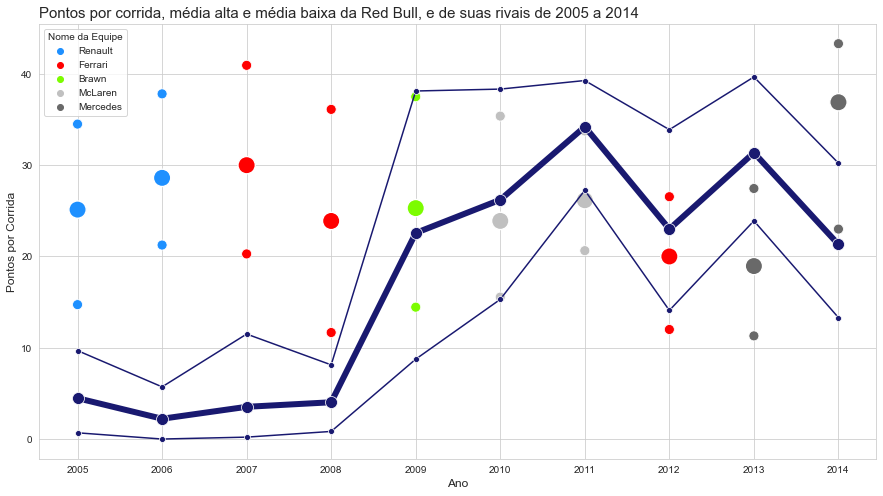

In [37]:
paleta = {'Renault': 'dodgerblue', 'Ferrari': 'red', 'Brawn': 'lawngreen', 'McLaren': 'silver', 'Mercedes': 'dimgrey'}
pontos_corrida_rbr = grafico_comparacao_pontos(rbr_05_14, rival_rbr, paleta,
                                    'Pontos por corrida, média alta e média baixa da Red Bull, e de suas rivais de 2005 a 2014', 
                                    'midnightblue')

#### Desvio Padrão da pontuação da Red Bull de 2005 a 2014

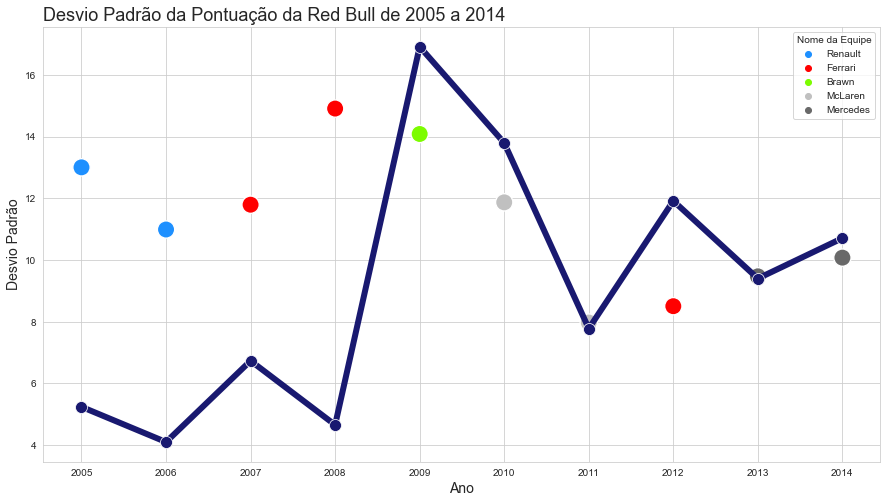

In [38]:
desvio_padrao_rbr = grafico_comparacao('std', rbr_05_14, rival_rbr, paleta, 
                                       'Desvio Padrão da Pontuação da Red Bull de 2005 a 2014', 'Desvio Padrão', 'midnightblue')

<!-- novo --> A Red Bull teve um crescimento muito grande no ano de 2009, mas foi muito inconstante. Ela teve resultados bons tão bons quanto da Brawn GP, porém seus resultados ruins foram muito piores que os da Brawn. Seu desvio padrão e a distância da média alta e média baixa para a média geral demonstram isso. Mas para que haja uma análise mais completa, é necessário aproximar uma lupa, logo, todos os resultados da Red Bull e da Brawn GP, em 2009, serão analisados.

É quase o mesmo caso olhando para 2010, média baixa da Red Bull e da McLaren são quase idênticas, porém, a McLaren não teve bons resultados tão bons quanto da Red Bull, por isso sua média alta é menor que da Red Bull. A McLaren até teve um desvio padrão menor, mas isso não quer dizer muita coisa, só quer dizer que ela foi mais constante durante a temporada, no entanto ela pode ter sido mais constante porém com resultados piores, que aparentemente é o caso. Contudo, a lupa será utilizada, e a temporada de 2010 das duas equipes será analisada.

2012 também é um ano interessante de ser analisado, as médias e médias baixas das equipes Red Bull e Ferrari são relativamente parecidas, porém, a média alta da Red Bull é muito maior que a média da Ferrari. Ou seja, as equipes tiveram um desempenho relativamente parecido, porém, quando a Red Bull foi bem, ela desempenhou muito melhor que a Ferrari quando foi bem. Isso é demonstrado pelo desvio padrão mais alto da Red Bull. A Ferrari pode até ter sido mais constante, porém teve muitos resultados medianos, o que favoreceu a Red Bull, que teve resultados melhores. Contudo, a lupa também será utilizada em 2012. 

A seguir, os gráficos das pontuações em cada corrida da Red Bull e suas rivais em 2009, 2010 e 2012

#### Resultados da Red Bull e sua rival em cada corrida de 2009

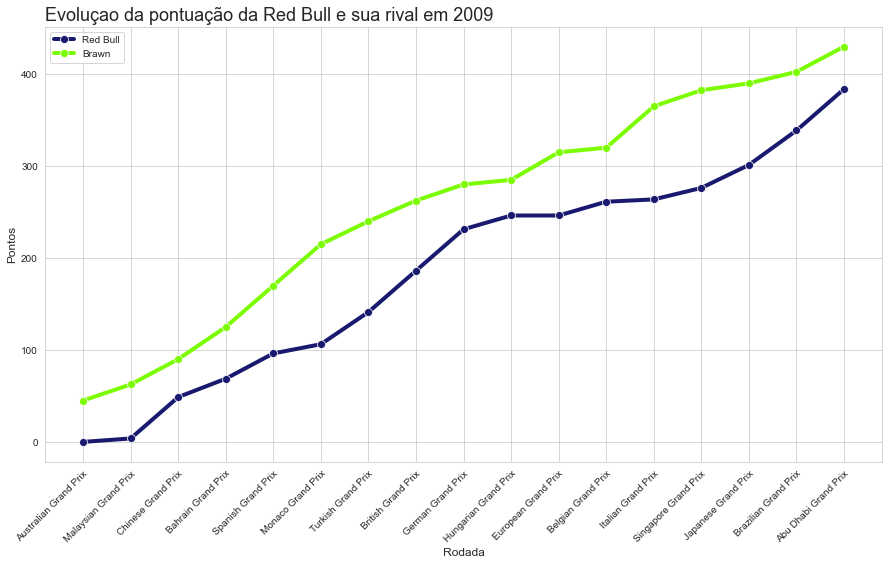

In [39]:
grafico_results_rbr_2009 = grafico_evolucao_pontuacao(resultados_rbr_2009, resultados_rival_rbr_2009, 'midnightblue', 'lawngreen', 
                                                        'Evoluçao da pontuação da Red Bull e sua rival em 2009')

<!-- novo -->É possível perceber que os resultados de ambas as equipes são relativamente semelhantes ao longo da temporada, com a Brawn GP tendo um início de temporada melhor, e a Red Bull tendo um meio e um fim de temporada melhor. 

Porém, é possível perceber que a Brawn GP tem menos períodos em que a curva cresce pouco, então ela teve menos resultados ruins, porém quando a curva da Red Bull sobe, ela sobe muito mais do que quando a curva da Brawn GP sobe. Logo, é possível explicar a Média Alta da Red Bull mais alta que a Média Alta da Brawn GP e também é possível explicar a Média Baixa de ambas as equipes. 

E como a pontuação da Brawn GP sobe em um ritmo mais constante que a pontuação da Red Bull, o Desvio Padrão da equipe de Ross Brawn é menor que da equipe austríaca.

<!-- novo -->

#### Resultados da Red Bull e sua rival em cada corrida de 2010

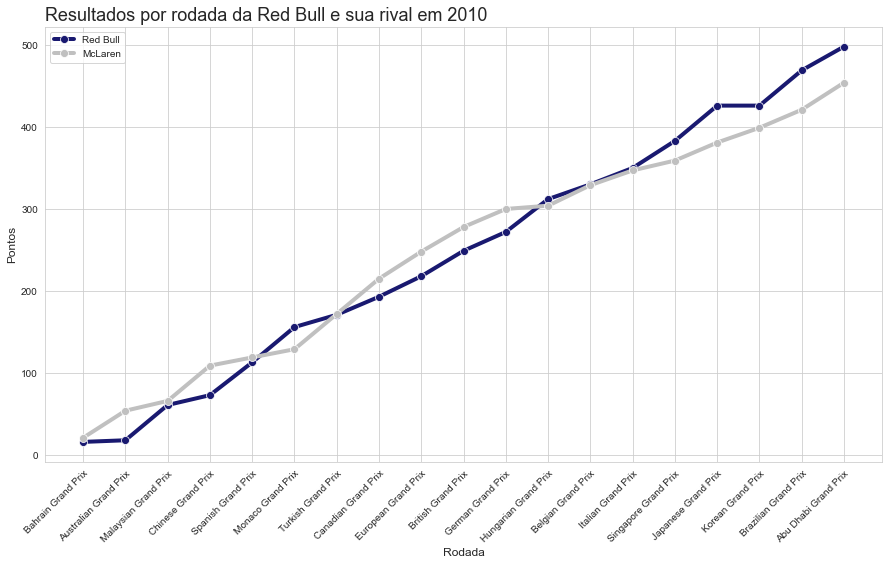

In [40]:
grafico_results_rbr_2010 = grafico_evolucao_pontuacao(resultados_rbr_2010, resultados_rival_rbr_2010, 'midnightblue', 'silver', 
                                                       'Resultados por rodada da Red Bull e sua rival em 2010')

O início de temporada de temporada de ambas equipes é relativamente parecido quanto a "não regularidade", porém mais para o meio da temporada, a pontuação da McLaren fica num ritmo de crescimento muito mais estável, e a Red Bull também, mas após o GP da Hungria a Red Bull tem uma pontuação a McLaren em duas corridas, entretanto após 3 corridas, a Red Bull pontua muito mais que a McLaren.

A RBR até não pontua no GP da Coréia, mas como sua pontuação antes e depois dessa corrida é muito maior que a pontuação da equipe de Woking, a Red Bull se sagra campeã.

Como os resultados ruins da equipe são semelhantes, sua Média Baixa também vai ser semlhante, porém as grandes pontuações da Red Bull são maiores do que as grandes pontuações da McLaren, o que explica sua Média Alta maior.

#### Resultados da Red Bull e sua rival em cada corrida de 2012

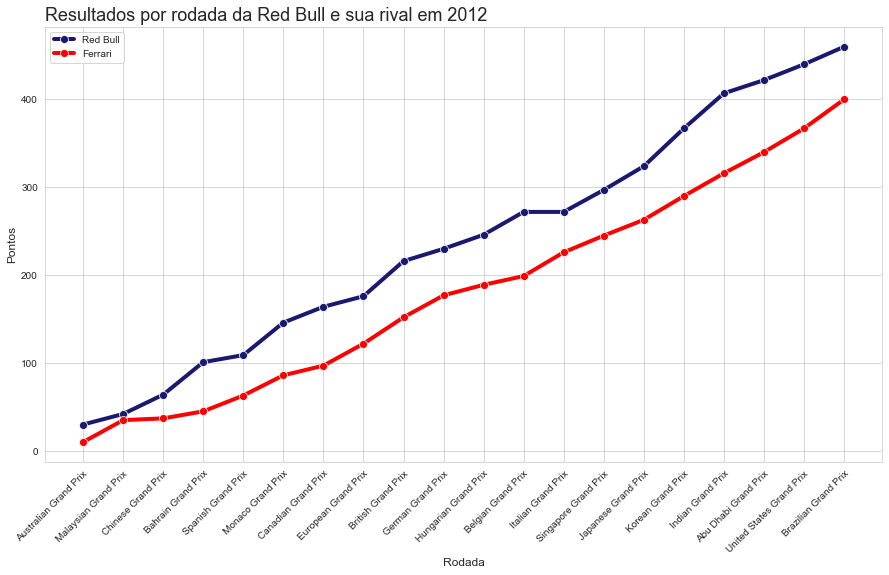

In [41]:
grafico_results_rbr_2012 = grafico_evolucao_pontuacao(resultados_rbr_2012, resultados_rival_rbr_2012, 'midnightblue', 'r', 
                                                       'Resultados por rodada da Red Bull e sua rival em 2012')

É possível perceber que a pontuação da Ferrari tem um ritmo de crescimento muito mais constante ao longo da temporada do que a Red Bull, entretanto, a Red Bull tem um crescimento muito maior (apesar de ser uma curva mais instável, que justifica seu Desvio Padrão). Porém, quando a pontuação da Red Bull está estável, ela é parecida com a pontuação da Ferrari. 

A diferença está nas "anormalidades": a Ferrari tem uma pontuação muito constante, então qualquer pontuação ruim já conta muito para baixar a Média Baixa da equipe de Maranello. E como a pontuação é muito constante, qualquer resultado melhor que a normalidade já vai erguer muito a Média Alta da Ferrari. 

Já com a Red Bull o caso é diferente. Já que as pontuações ruins da Red Bull são parecidas com as pontuações ruins da Ferrari, a Média Baixa da Red Bull será parecida com a Média Baixa da Ferrari. Porém, as pontuações altas da Red Bull são muito maiores que as pontuações altas da Ferrari, o que justifica sua Média Alta muito maior que a Média Alta da Ferrari.

#### Posição da Red Bull no campeonato de construtores de 2005 a 2014

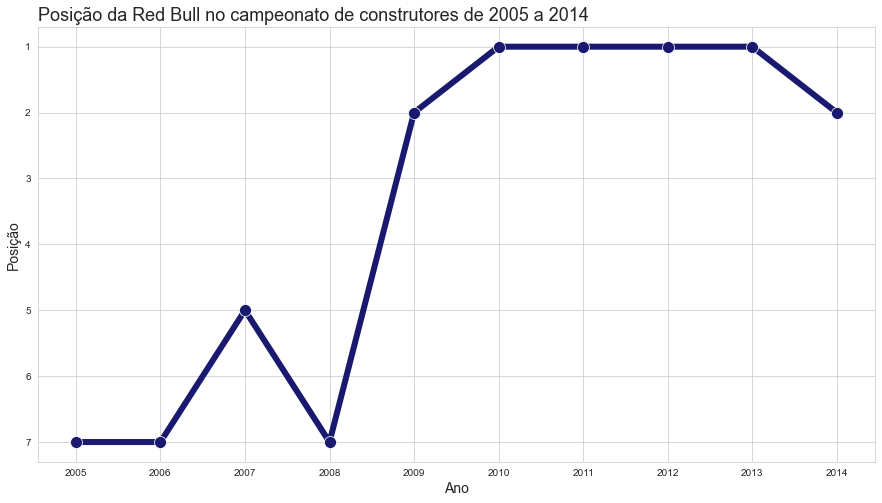

In [42]:
posicao_rbr = grafico_posicao('position', rbr_05_14, 'Posição da Red Bull no campeonato de construtores de 2005 a 2014',
                              'Posição', 'midnightblue')

#### Vitórias da Red Bull e suas rivais de 2005 a 2014

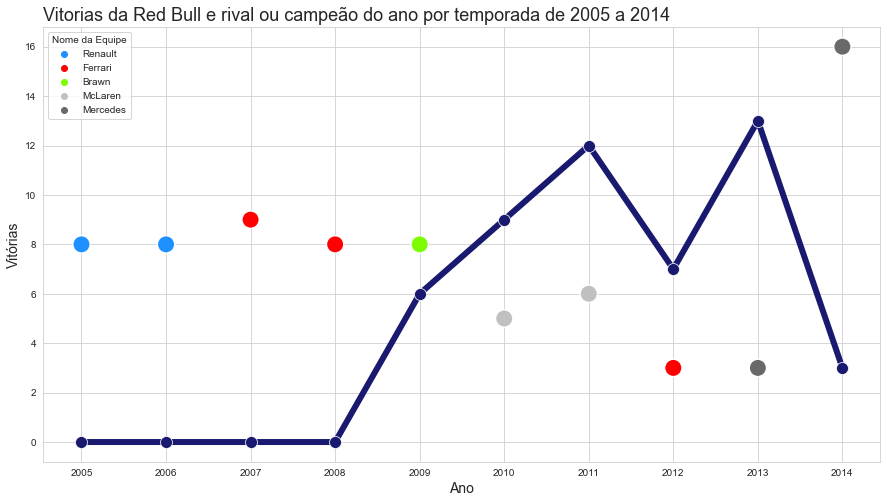

In [43]:
vitorias_rbr = grafico_comparacao('wins', rbr_05_14, rival_rbr, paleta, 
                                  'Vitorias da Red Bull e rival ou campeão do ano por temporada de 2005 a 2014', 
                                  'Vitórias', 'midnightblue')

#### Poles da Red Bull e suas rivais de 2005 a 2014

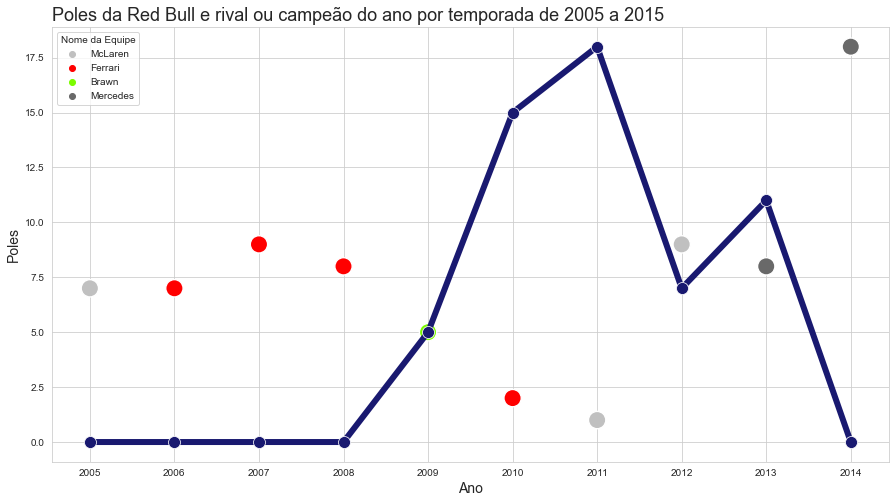

In [44]:
grafico_poles_rbr = grafico_comparacao('poles_count', poles_rbr, rival_poles_rbr, paleta, 
                                  'Poles da Red Bull e rival ou campeão do ano por temporada de 2005 a 2015', 
                                  'Poles', 'midnightblue')

### <font color=MidnightBlue> Conclusão

Conclui-se que no ano de 2009 a Red Bull teve um grande salto de seu desempenho comparado aos seus três anos anteriores, que foram relativamente medíocres. Esse salto, "coincidente" com a mudança do regulamento (e talvez uma maior quantidade de dinheiro disponível) aconteceu em 2009, e logo no ano seguinte, onde a Brawn GP não existia mais e os concorrentes da Red Bull estavam relativamente abaixo da mesma, a Red Bull levou seu primeiro título, com uma certa vantagem até.
Até o momento, a hipótese do salto de desempenho no ano anterior vêm se confirmando, mas é impossível confirmar algo com somente uma um dado, por isso, a dominação da Mercedes de 2014 até o presente momento (escrito em 2020) será analisada.

---

## <font color=silver>Analisando a Dominância da Mercedes-AMG Petronas Formula One Team (2014-presente)

Beneficiada por uma mudança de tecnologia dos motores e da aerodinâmica, a Mercedes se tornou uma equipe muito dominante, batendo muitos recordes. Ela entrou em 2010, e até então, ela era uma equipe sem muitos destaques, com poucas vitórias, poucas poles, sem nada demais. Porém, com a entrada da tecnologia híbrida de motorização e consequentes alterações aerodinâmicas, a dominação Mercedista começou. 

Obviamente que essa dominância teve uma grande ajuda da mudança do regulamento técnico, porém, será que a Mercedes teve algum salto de desempenho em um ano anterior a sua dominância que pudesse indicar que a mesma viria muito forte para o próximo ano? É o que vamos descobrir nessa análise.

In [45]:
mercedes_10_19 = None
rival_mercedes = None
poles_mercedes = None
rival_poles_mercedes = None

### 2010 a 2012

In [46]:
final_mercedes_2010, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2010, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2010, poles_mercedes, rival_poles_mercedes = filtra_pole(2010, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2010, resultados_rival_mercedes_2010 = resultados_ano(2010, 'Mercedes')

In [47]:
final_mercedes_2011, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2011, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2011, poles_mercedes, rival_poles_mercedes = filtra_pole(2011, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2011, resultados_rival_mercedes_2011 = resultados_ano(2011, 'Mercedes')

In [48]:
final_mercedes_2012, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2012, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2012, poles_mercedes, rival_poles_mercedes = filtra_pole(2012, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2012, resultados_rival_mercedes_2012 = resultados_ano(2012, 'Mercedes')

### Analisando o Ano de 2013 da Mercedes

In [49]:
final_mercedes_2013, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2013, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2013, poles_mercedes, rival_poles_mercedes = filtra_pole(2013, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2013, resultados_rival_mercedes_2013 = resultados_ano(2013, 'Mercedes')

#### Traçando os gráficos de 2013

##### Pontos de cada equipe em 2013

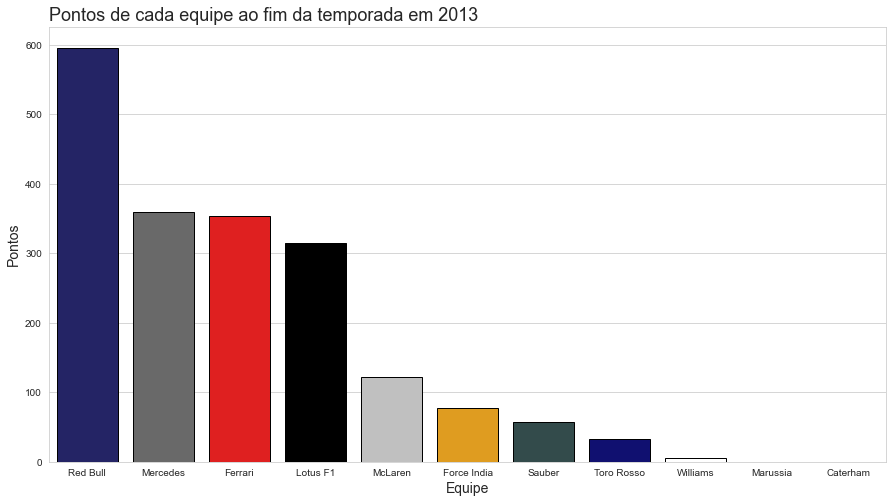

In [50]:
paleta = {'Red Bull': 'midnightblue', 'McLaren': 'silver', 'Ferrari': 'red', 'Williams': 'white', 'Lotus F1': 'black', 
          'Force India': 'orange', 'Toro Rosso': 'navy', 'Mercedes': 'dimgray', 'Sauber': 'darkslategrey', 'Marussia': 'tab:red', 'Caterham': 'Green'}
pontos_2013 = grafico('points', final_mercedes_2013, 
        'Pontos', 'Pontos de cada equipe ao fim da temporada em 2013', paleta)

##### Vitórias de cada equipe em 2013

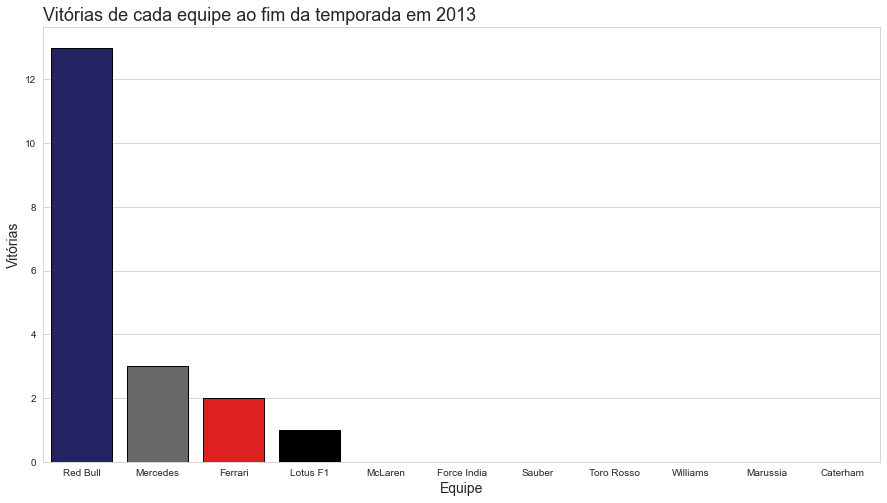

In [51]:
vitorias_2013 = grafico('wins', final_mercedes_2013,
        'Vitórias', 'Vitórias de cada equipe ao fim da temporada em 2013', paleta)

<h5>Quantidade de poles de cada equipe em 2013</h5>

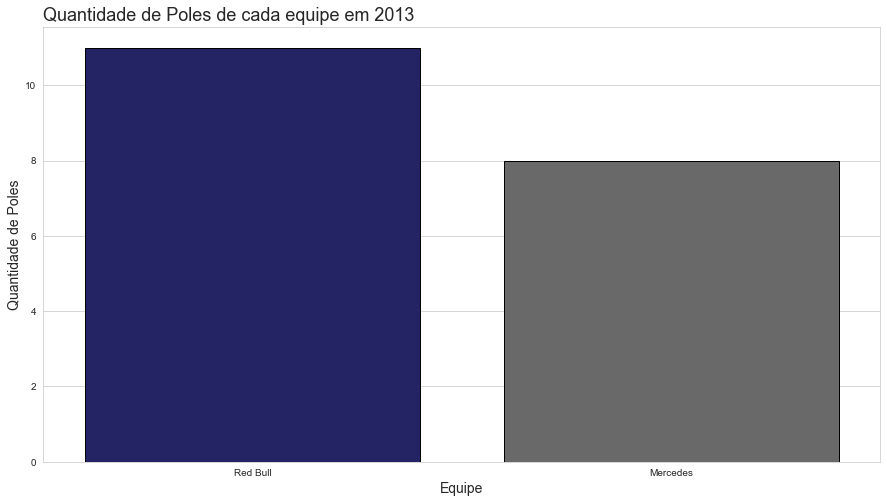

In [52]:
pole_positions_2013 = grafico('poles_count', poles_2013, 
                              'Quantidade de Poles', 'Quantidade de Poles de cada equipe em 2013', paleta)

#### Análise de 2013

É possível perceber um salto de desempenho na Mercedes. De uma equipe que vinha "decaindo", caindo do quarto para o quinto lugar no Campeonato de Construtores de 2011 para 2012 e tinha apenas uma vitória, ela conseguiu subir muito. Ela conseguiu um segundo lugar (apertado, mas conseguiu) no campeonato de construtores, conseguiu três vitórias, algo surpreendente vistos seus anos anteriores.

### Analisando o Ano de 2014 da Mercedes

In [53]:
final_mercedes_2014, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2014, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2014, poles_mercedes, rival_poles_mercedes = filtra_pole(2014, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2014, resultados_rival_mercedes_2014 = resultados_ano(2014, 'Mercedes')

#### Traçando os gráficos de 2014

##### Pontos de cada equipe em 2014

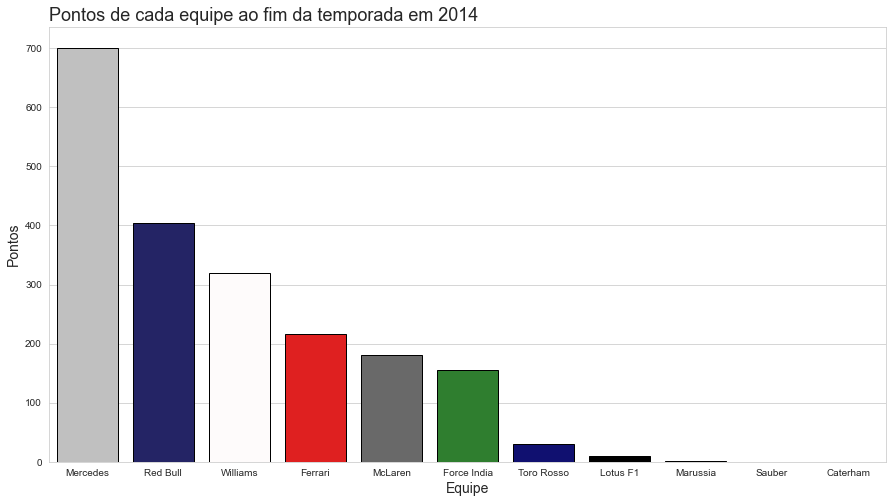

In [54]:
paleta = {'Red Bull': 'midnightblue', 'McLaren': 'dimgray', 'Ferrari': 'red', 'Williams': 'snow', 'Lotus F1': 'black', 
          'Force India': 'forestgreen', 'Toro Rosso': 'navy', 'Mercedes': 'silver', 'Sauber': 'darkslategrey', 'Marussia': 'tab:red', 'Caterham': 'Green'}
pontos_2014 = grafico('points', final_mercedes_2014,
        'Pontos', 'Pontos de cada equipe ao fim da temporada em 2014', paleta)

##### Vitórias de cada equipe em 2014

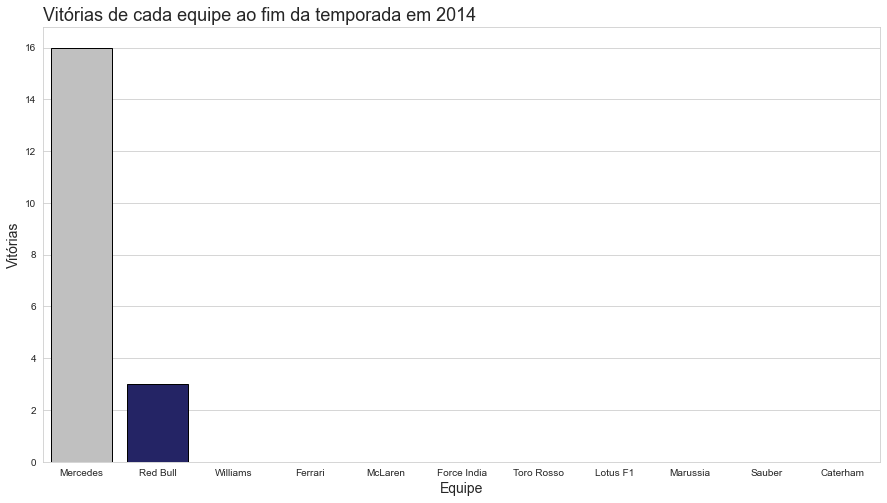

In [55]:
vitorias_2014 = grafico('wins', final_mercedes_2014, 
        'Vitórias', 'Vitórias de cada equipe ao fim da temporada em 2014', paleta)

##### Quantidade de poles de cada equipe em 2014

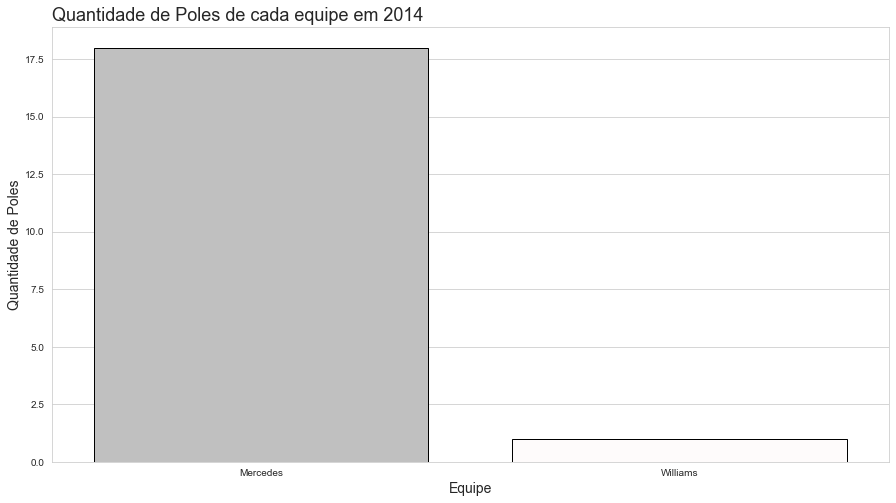

In [56]:
pole_positions_2014 = grafico('poles_count', poles_2014, 
                              'Quantidade de Poles', 'Quantidade de Poles de cada equipe em 2014', paleta)

#### Análise de 2014

É possível possível perceber um enorme salto de desempenho da Mercedes em 2014, coincidentemente (ou não), o ano em que mudanças no Regulamento Técnico aconteceram. E em seu ano anterior, já era possível perceber um certo salto, um pouco discreto comparado a 2014, mas já era possível perceber uma mudança.

### 2015 a 2019

In [57]:
final_mercedes_2015, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2015, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2015, poles_mercedes, rival_poles_mercedes = filtra_pole(2015, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2015, resultados_rival_mercedes_2015 = resultados_ano(2015, 'Mercedes')

In [58]:
final_mercedes_2016, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2016, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2016, poles_mercedes, rival_poles_mercedes = filtra_pole(2016, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2016, resultados_rival_mercedes_2016 = resultados_ano(2016, 'Mercedes')

In [59]:
final_mercedes_2017, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2017, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2017, poles_mercedes, rival_poles_mercedes = filtra_pole(2017, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2017, resultados_rival_mercedes_2017 = resultados_ano(2017, 'Mercedes')

In [60]:
final_mercedes_2018, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2018, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2018, poles_mercedes, rival_poles_mercedes = filtra_pole(2018, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2018, resultados_rival_mercedes_2018 = resultados_ano(2018, 'Mercedes')

In [61]:
final_mercedes_2019, mercedes_10_19, rival_mercedes = seleciona_pontuacao(2019, 'Mercedes', mercedes_10_19, rival_mercedes)
poles_2019, poles_mercedes, rival_poles_mercedes = filtra_pole(2019, poles_mercedes, rival_poles_mercedes, 'Mercedes')
resultados_mercedes_2019, resultados_rival_mercedes_2019 = resultados_ano(2019, 'Mercedes')

In [62]:
rival_mercedes.rename(columns = {'team_name': 'Nome da Equipe'}, inplace = True)
rival_poles_mercedes.rename(columns = {'team_name': 'Nome da Equipe'}, inplace = True)
poles_mercedes['year'] = range(2010, 2020)
rival_poles_mercedes['year'] = range(2010, 2020)

### <font color=silver>Desempenho da Mercedes em cada ano

In [63]:
mercedes_10_19

,year,round,circuitId,name,points,position,wins,team_name,points_per_race,higher_medium,lower_medium,std
3,2010,19,24,Abu Dhabi Grand Prix,214.0,4,0,Mercedes,11.263158,14.909091,6.250000,5.566189
3,2011,19,18,Brazilian Grand Prix,165.0,4,0,Mercedes,8.684211,12.636364,3.250000,5.578258
4,2012,20,18,Brazilian Grand Prix,142.0,5,1,Mercedes,7.100000,15.571429,2.538462,7.765646
1,2013,19,18,Brazilian Grand Prix,360.0,2,3,Mercedes,18.947368,27.444444,11.300000,9.472027
0,2014,19,24,Abu Dhabi Grand Prix,701.0,1,16,Mercedes,36.894737,43.307692,23.000000,10.076897
0,2015,19,24,Abu Dhabi Grand Prix,703.0,1,16,Mercedes,37.000000,42.571429,21.400000,10.551461
0,2016,21,24,Abu Dhabi Grand Prix,765.0,1,19,Mercedes,36.428571,41.200000,24.500000,10.628130
0,2017,20,24,Abu Dhabi Grand Prix,668.0,1,12,Mercedes,33.400000,39.300000,27.500000,7.450892
0,2018,21,24,Abu Dhabi Grand Prix,655.0,1,11,Mercedes,31.190476,38.700000,24.363636,9.968044
0,2019,21,24,Abu Dhabi Grand Prix,739.0,1,15,Mercedes,35.190476,42.000000,21.571429,12.221371


### <font color=silver> Desempenho das rivais da Mercedes em cada ano

In [64]:
rival_mercedes

,year,round,circuitId,name,points,position,wins,Nome da Equipe,points_per_race,higher_medium,lower_medium,std
0,2010,19,24,Abu Dhabi Grand Prix,498.0,1,9,Red Bull,26.210526,38.333333,15.300000,13.794439
0,2011,19,18,Brazilian Grand Prix,650.0,1,12,Red Bull,34.210526,39.272727,27.250000,7.778738
0,2012,20,18,Brazilian Grand Prix,460.0,1,7,Red Bull,23.000000,33.888889,14.090909,11.916375
0,2013,19,18,Brazilian Grand Prix,596.0,1,13,Red Bull,31.368421,39.666667,23.900000,9.399826
1,2014,19,24,Abu Dhabi Grand Prix,405.0,2,3,Red Bull,21.315789,30.222222,13.300000,10.708525
1,2015,19,24,Abu Dhabi Grand Prix,428.0,2,3,Ferrari,22.526316,28.818182,13.875000,9.708922
1,2016,21,24,Abu Dhabi Grand Prix,468.0,2,2,Red Bull,22.285714,30.200000,15.090909,9.649574
1,2017,20,24,Abu Dhabi Grand Prix,522.0,2,5,Ferrari,26.100000,33.833333,14.500000,11.737928
1,2018,21,24,Abu Dhabi Grand Prix,571.0,2,6,Ferrari,27.190476,33.900000,21.090909,7.858874
1,2019,21,24,Abu Dhabi Grand Prix,504.0,2,3,Ferrari,24.000000,29.307692,15.375000,9.192388


### <font color=silver> Analisando anos anteriores, a dominação e o ano posterior ao domínio da Mercedes

#### Pontos por corrida, média alta e média baixa da Mercedes e suas rivais de 2010 a 2019

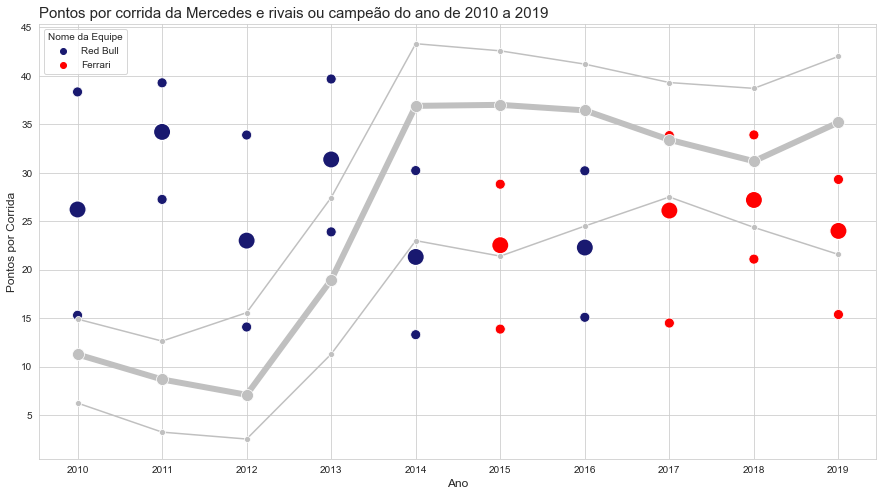

In [65]:
paleta = {'Red Bull': 'midnightblue', 'Ferrari': 'red'}
pontos_corrida_merc = grafico_comparacao_pontos(mercedes_10_19, rival_mercedes, paleta, 
                                        'Pontos por corrida da Mercedes e rivais ou campeão do ano de 2010 a 2019', 
                                        'silver')

#### Desvio Padrão da Mercedes e suas rivais de 2010 a 2019

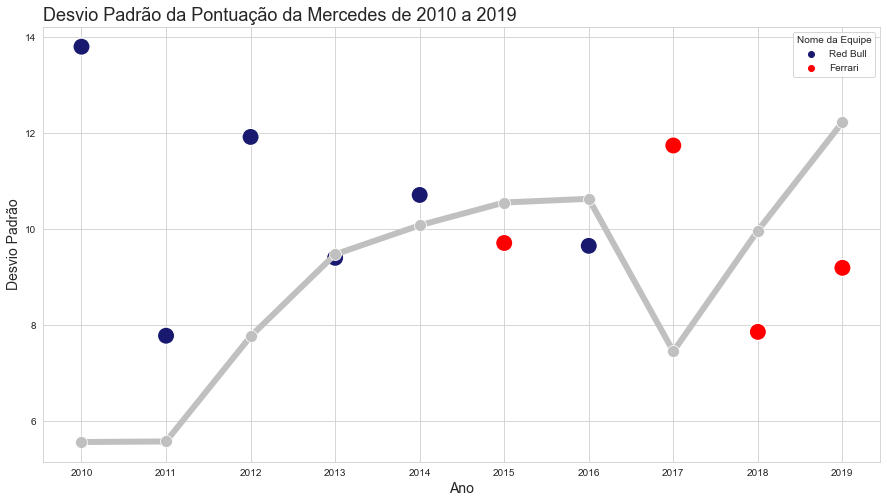

In [66]:
desvio_padrao_merc = grafico_comparacao('std', mercedes_10_19, rival_mercedes, paleta, 
                                       'Desvio Padrão da Pontuação da Mercedes de 2010 a 2019', 'Desvio Padrão', 'silver')

<!-- novo/explicar o porque de analisar 2012, 2013, 2015, 2017 e 2019/--> Em 2012, o desvio padrão da Mercedes aumenta muito comparado aos anos anteriores, sua Média Baixa continua baixando, seguindo sua tendência, sua Média também segue a tendência de queda, porém sua Média Alta quebra a tendência, ela sobre muito comparada aos seus anos anteriores. É necessário analisar o ano mais "de perto" para descobrir as razões disso acontecer.

Já 2013 é um ano de muito crescimento para a Mercedes, é possível perceber isso nas três Médias e no Desvio Padrão (quanto maior o desempenho da equipe, é mais fácil ter um Desvio Padrão alto). Ter um olhar mais próximo é algo bom, e é por isso que 2013 será analisado mais detalhadamente.

2015 é um ano interessante, a Média Baixa desce muito comparando com o ano anterior, a Média Alta desce um pouco e a Média é praticamente a mesma, ao mesmo tempo que o Desvio Padrão sobe. 2015 será analisado mais de perto.

No entanto, 2017 é um ano em que a Média Baixa sobe, a Média e a Média Alta crescem, ao mesmo tempo que o Desvio Padrão decresce muito. É um ano em que aparentemente, o desempenho decresce, porém é um ano muito constante (evidenciado pelo menor Desvio Padrão e pela menor distância entre as Médias Alta e Baixa na dominância). Também será um ano analisado de perto.

Em 2019, há o maior Desvio Padrão de todos, a Média Baixa desce em comparação ao ano anterior, a Média Alta sobe e a Média sobe também. Pode ser um ano interessante de ser analisado.

#### Resultados da Mercedes e sua rival em 2012

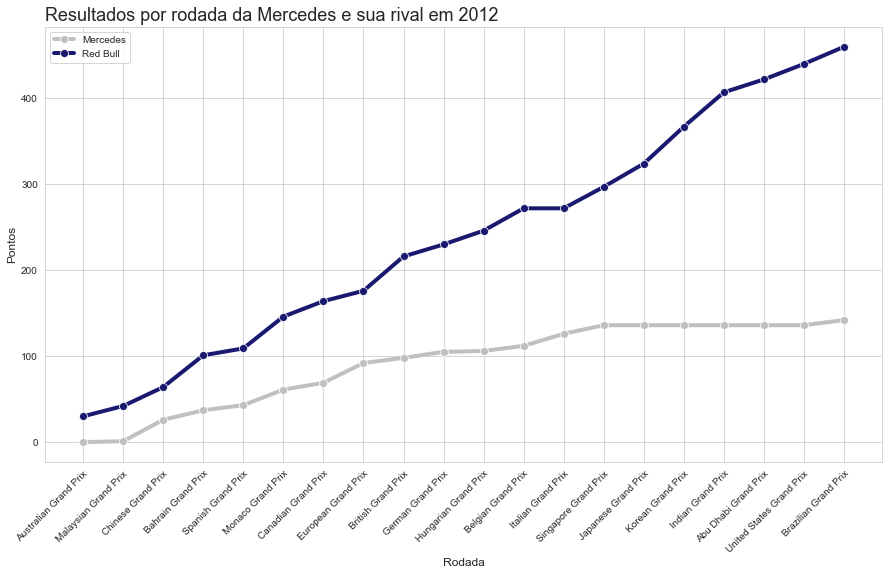

In [67]:
graf_results_merc_2012 = grafico_evolucao_pontuacao(resultados_mercedes_2012, resultados_rival_mercedes_2012, 'silver', 'midnightblue', 
                                                     'Resultados por rodada da Mercedes e sua rival em 2012')

<!-- novo -->É possível perceber que a Mercedes teve alguns resultados ruins ao longo da temporada, principalmente do período do GP de Singapura até o GP dos Estados Unidos. Tantos resultados ruins puxam a Média Baixa para baixo. Entretanto, a Mercedes teve uma vitória na temporada, no GP da China, e também teve um bom resultado no GP da Europa, e esses resultados fizeram a Média Alta quebrar a tendência de baixa que ela tinha e subir muito, comparando com os anos anteriores. Tantos pontos altos e baixos se traduzem num desvio padrão mais alto que nos anos anteriores, quando a equive teve somente resultados medianos.

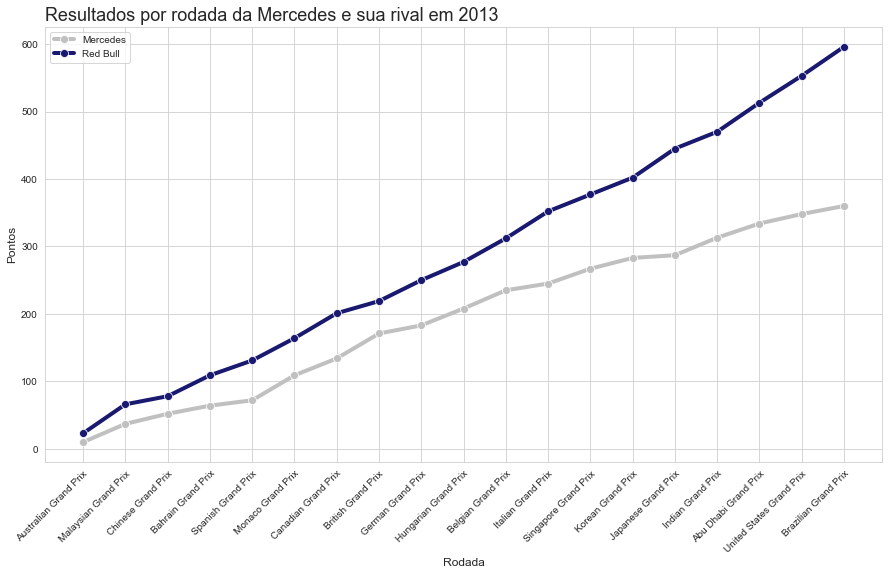

In [68]:
graf_results_merc_2013 = grafico_evolucao_pontuacao(resultados_mercedes_2013, resultados_rival_mercedes_2013, 'silver', 'midnightblue', 
                                                     'Resultados por rodada da Mercedes e sua rival em 2013')

<!-- novo --> A Mercedes em 2013 tem um desempenho relativamente constante em alguns períodos da temporada, que curiosamente são os períodos em que sua curva menos cresce, porém há alguns períodos em que a curva de pontos da Mercedes cresce muito. Esses "altos e baixos" justificam seu Desvio Padrão relativamente alto.

Não há "anomalias" nas Média Alta e Baixa, mas é possível perceber que a equipe foi relativamente constante ao longo da temporada apesar dos "altos e baixos", então as médias estão relativamente próximas.

#### Resultados da Mercdes e sua rival em 2015

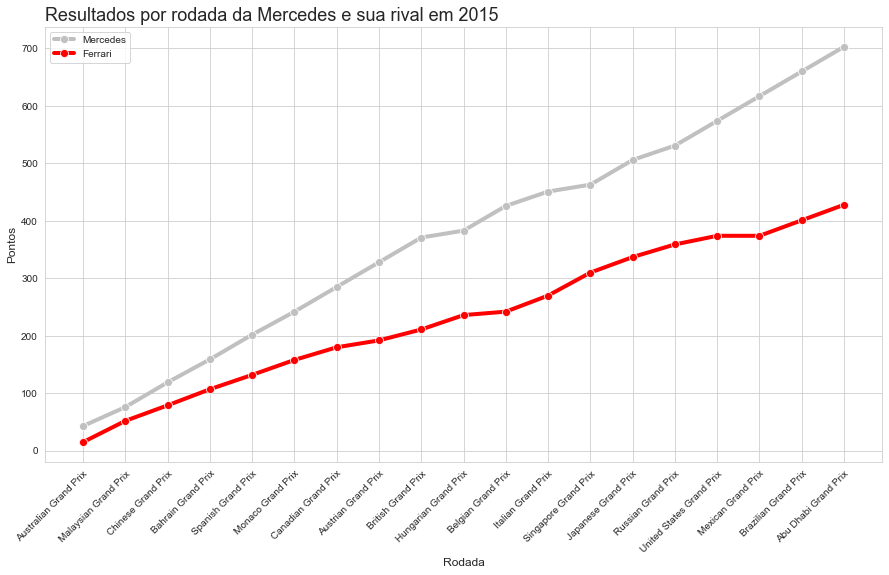

In [69]:
graf_results_merc_2015 = grafico_evolucao_pontuacao(resultados_mercedes_2015, resultados_rival_mercedes_2015, 'silver', 'red', 
                                                     'Resultados por rodada da Mercedes e sua rival em 2015')

Algo que chama muita atenção no gráfico das Médias da Mercedes, é que em 2015 a Média Baixa desce muito e o Desvio Padrão cresce, porém analisando o gráfico da evolução da pontuação ao longo da temporada, é perceptível que com exceção de poucas ocasiões, a Mercedes é extremamente constante ao longo da temporada.

O Desvio Padrão e a Média Baixa tiveram essas variações justamente pela constância da equipe ao longo da temporada. Como foram poucos resultados ruins e muitos resultados perto da Média (ou mais altos que a Média), a Média Baixa será calculada com poucos valores, e isso acarretará numa Média Baixa menor. 

Com o Desvio Padrão é o mesmo caso, como são muitos resultados perto da Média e poucos longe da Média (e muito longe), o Desvio Padrão será mais alto.

#### Resultados da Mercedes e sua rival em 2017

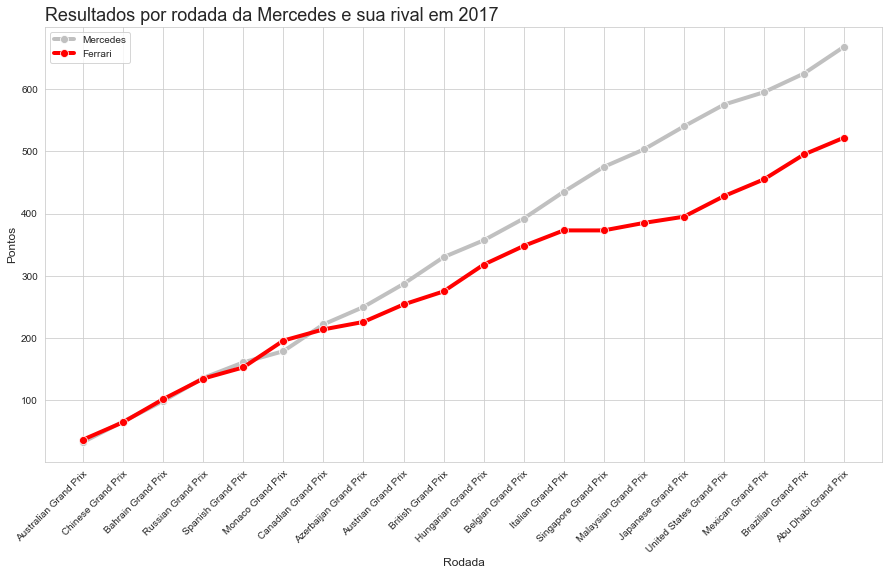

In [70]:
graf_results_merc_2017 = grafico_evolucao_pontuacao(resultados_mercedes_2017, resultados_rival_mercedes_2017, 'silver', 'red', 
                                                     'Resultados por rodada da Mercedes e sua rival em 2017')

2017 foi o ano mais regular da Mercedes, isso é perceptível por sua curva da evolução de pontos ao longo da temporada, que é quase uma reta. Por conta de haver poucas alterações bruscas (com exceção do GP de Mônaco), o Desvio Padrão será baixo (o menor desde 2012) e as Médias Alta e Baixa serão muito próximas.

#### Resultados da Mercedes e sua rival em 2019

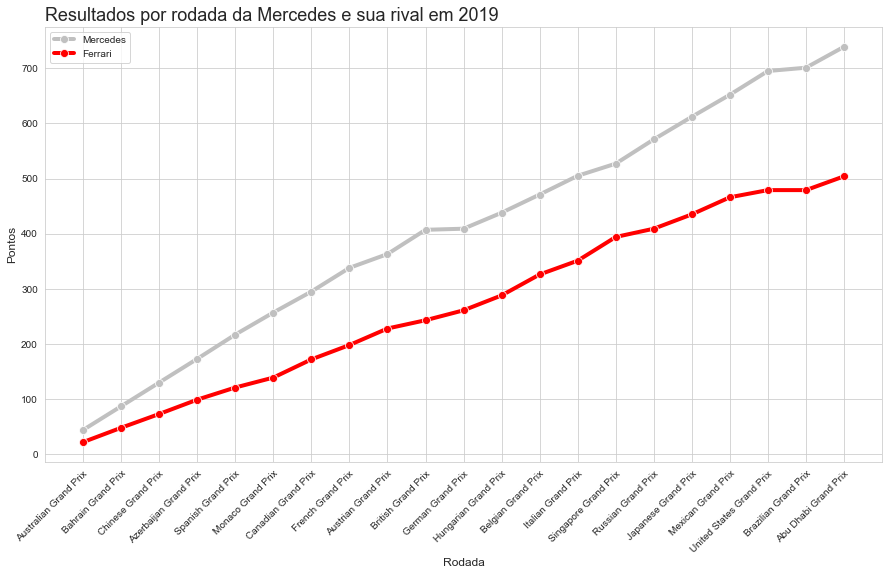

In [71]:
graf_results_merc_2019 = grafico_evolucao_pontuacao(resultados_mercedes_2019, resultados_rival_mercedes_2019, 'silver', 'red', 
                                                     'Resultados por rodada da Mercedes e sua rival em 2019')

2019 é o ano que a Mercedes tem seu maior Desvio Padrão, o que pode indicar que ela não foi tão constante, porém analisando o gráfico da evolução dos pontos ao longo da temporada, percebe-se que a Mercedes é extremamente constante, sempre tendo ótimos resultados. Há exceções, duas delas sendo muito marcantes, o GP da Alemanha e o GP do Brasil. Por serem resultados que destoam muito do resto da temporada, eles elevaram muito o Desvio Padrão da Equipe.

Também pela equipe ser muito constante e ter somente dois resultados ruins, sua Média Baixa também vai ser relativamente baixa (como observado no gráfico da média de pontos por corrida em cada temporada).

Ademais, a por conta da equipe ser extemamente constante e com ótimos resultados, a Média e a Média Alta sobem, atingindo quase os patamares dos anos mais dominantes da equipe de Brackley.

#### Posição da Mercedes no campeonato de construtores de 2010 a 2019

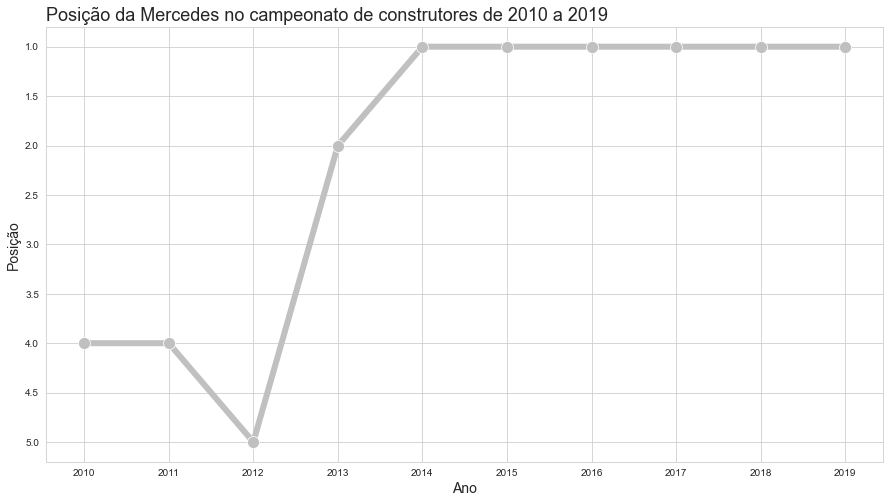

In [72]:
posicao_mercedes = grafico_posicao('position', mercedes_10_19, 
                                   'Posição da Mercedes no campeonato de construtores de 2010 a 2019', 
                                   'Posição', 'silver')

#### Vitórias da Mercedes e suas rivais de 2010 a 2019

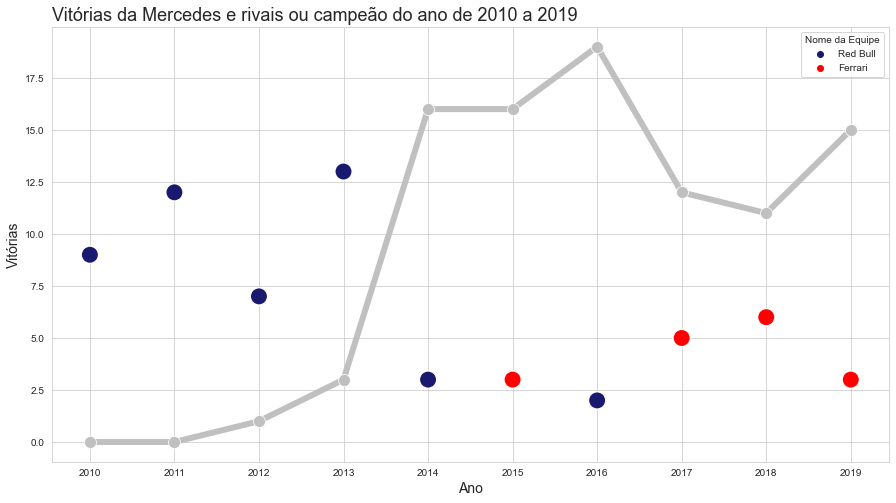

In [73]:
vitorias_merc = grafico_comparacao('wins', mercedes_10_19, rival_mercedes, paleta, 
                                  'Vitórias da Mercedes e rivais ou campeão do ano de 2010 a 2019', 'Vitórias', 'silver')

#### Poles da Mercedes e suas rivais de 2010 a 2019

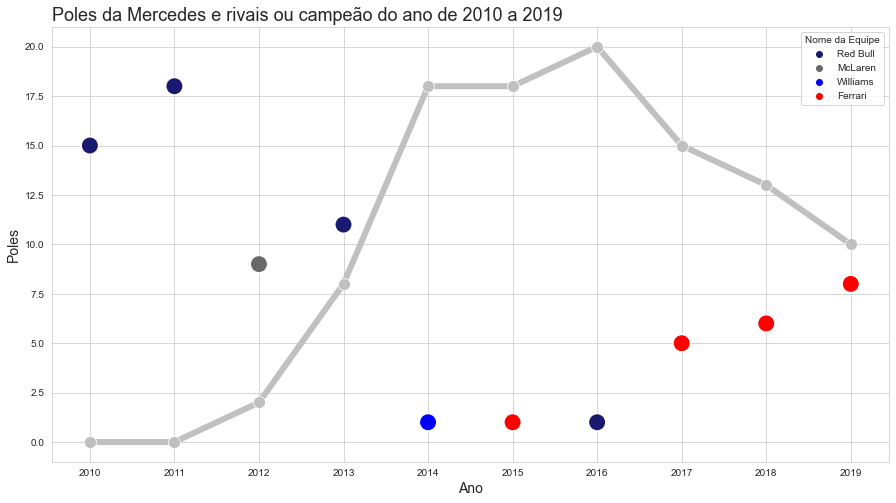

In [74]:
paleta = {'Red Bull': 'midnightblue', 'McLaren': 'dimgray', 'Ferrari': 'red', 'Williams': 'blue'}
poles_merc = grafico_comparacao('poles_count', poles_mercedes, rival_poles_mercedes, paleta, 
                                        'Poles da Mercedes e rivais ou campeão do ano de 2010 a 2019', 'Poles', 'silver')

### <font color=silver> Conclusão

Até o momento, a hipótese se confirma. O ano anterior a dominação de uma equipe já apresenta um certo salto, não tão grande quanto do primeiro ano da dominância, porém um salto relativamente grande comparado aos anos anteriores.

Com a Red Bull isso é evidente e com a Mercedes também. Há um salto grande no número de pontos por corrida, um salto no número de poles, um salto grande na tabela do campeonato (de 5º lugar para 2º) e também há um salto mais discreto no número de vitórias no ano (1 para 3).

É um salto de desempenho pequeno comparado ao do ano seguinte, mas é grande comparado aos anos anteriores. 
Até o momento, a hipótese se confirma. Cabe à dominação da Ferrari de 1999 a 2004 desmentir ou confirmar.

---
## <font color=Red>Analisando a Dominância da Scuderia Ferrari Marlboro (1999 a 2004)

A Ferrari conquistou os títulos dos anos 1999 a 2004, tendo conquistado seu último título antes desse período em 1983 (um jejum de 16 anos). Alguns títulos ela conquistou por poucos pontos e outros ela conquistou com uma boa vantagem (2002 e 2004 principalmente).

Para esta análise, as Poles não serão utilizadas por haver inconsistência em certos dados (tanto que algumas linhas de código estão comentadas por conta do código dar erro).

In [118]:
ferrari_95_05 = None
rival_ferrari = None
poles_ferrari = None
rival_poles_ferrari = None

### 1992 a 1997

In [165]:
final_ferrari_1992, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1992, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1992, resultados_rival_ferrari_1992 = resultados_ano(1992, 'Ferrari')
#poles_1992, poles_ferrari, rival_poles_ferrari = filtra_pole(1992, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [120]:
final_ferrari_1993, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1993, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1993, resultados_rival_ferrari_1993 = resultados_ano(1993, 'Ferrari')
#poles_1993, poles_ferrari, rival_poles_ferrari = filtra_pole(1993, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [121]:
final_ferrari_1994, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1994, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1994, resultados_rival_ferrari_1994 = resultados_ano(1994, 'Ferrari')
poles_1994, poles_ferrari, rival_poles_ferrari = filtra_pole(1994, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [122]:
final_ferrari_1995, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1995, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1995, resultados_rival_ferrari_1995 = resultados_ano(1995, 'Ferrari')
poles_1995, poles_ferrari, rival_poles_ferrari = filtra_pole(1995, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [123]:
final_ferrari_1996, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1996, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1996, resultados_rival_ferrari_1996 = resultados_ano(1996, 'Ferrari')
poles_1996, poles_ferrari, rival_poles_ferrari = filtra_pole(1996, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [124]:
final_ferrari_1997, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1997, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1997, resultados_rival_ferrari_1997 = resultados_ano(1997, 'Ferrari')
poles_1997, poles_ferrari, rival_poles_ferrari = filtra_pole(1997, poles_ferrari, rival_poles_ferrari, 'Ferrari')

### 1998

In [125]:
final_ferrari_1998, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1998, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_1998, resultados_rival_ferrari_1998 = resultados_ano(1998, 'Ferrari')
poles_1998, poles_ferrari, rival_poles_ferrari = filtra_pole(1998, poles_ferrari, rival_poles_ferrari, 'Ferrari')

#### Traçando os gráficos de 1998

##### Pontos de cada equipe em 1998

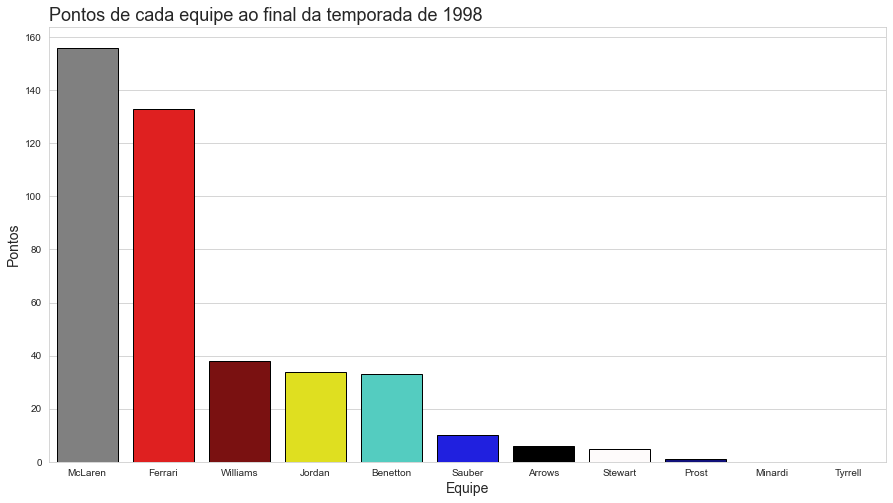

In [126]:
paleta = {'McLaren': 'gray', 'Ferrari': 'red', 'Williams': 'darkred', 'Jordan': 'yellow', 'Benetton': 'turquoise', 'Sauber': 'blue', 'Arrows': 'black',
         'Stewart': 'Snow', 'Prost': 'darkblue', 'Minardi': 'royalblue', 'Tyrrell': 'ghostwhite'}
pontos_1998 = grafico('points', final_ferrari_1998, 
                      'Pontos', 'Pontos de cada equipe ao final da temporada de 1998', paleta)

##### Vitórias de cada equipe em 1998

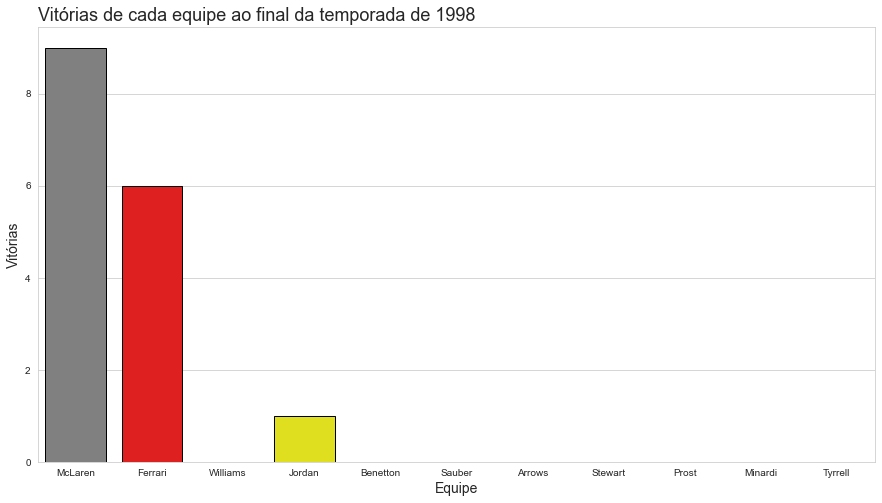

In [127]:
vitorias_1998 = grafico('wins', final_ferrari_1998, 
                      'Vitórias', 'Vitórias de cada equipe ao final da temporada de 1998', paleta)

#### Análise de 1998

1998 foi um ano em que a McLaren venceu com certa vantagem. Teve cerca de 20 pontos de vantagem (sendo 16 possíveis de serem conquistados em uma corrida, com a equipe tendo 1º e 2º lugar), além de ter vencido três corridas a mais.

### 1999

In [129]:
final_ferrari_1999, ferrari_95_05, rival_ferrari = seleciona_pontuacao(1999, 'Ferrari', ferrari_95_05, rival_ferrari,)
resultados_ferrari_1999, resultados_rival_ferrari_1999 = resultados_ano(1999, 'Ferrari')
poles_1999, poles_ferrari, rival_poles_ferrari = filtra_pole(1999, poles_ferrari, rival_poles_ferrari, 'Ferrari')

#### Traçando os gráficos de 1999

##### Pontos de cada equipe em 1999

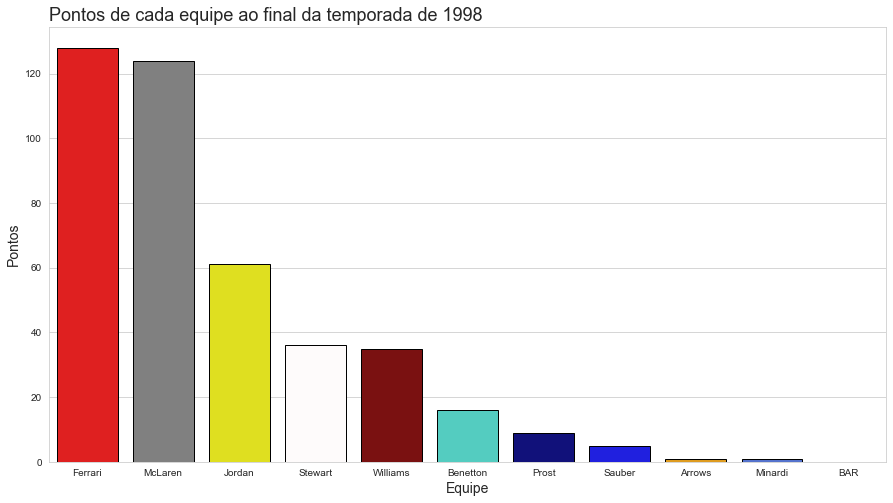

In [130]:
paleta = {'McLaren': 'gray', 'Ferrari': 'red', 'Williams': 'darkred', 'Jordan': 'yellow', 'Benetton': 'turquoise', 'Sauber': 'blue', 'Arrows': 'orange',
         'Stewart': 'Snow', 'Prost': 'darkblue', 'Minardi': 'royalblue', 'BAR': 'firebrick'}
pontos_1999 = grafico('points', final_ferrari_1999, 
                      'Pontos', 'Pontos de cada equipe ao final da temporada de 1998', paleta)

##### Vitórias de cada equipe em 1999

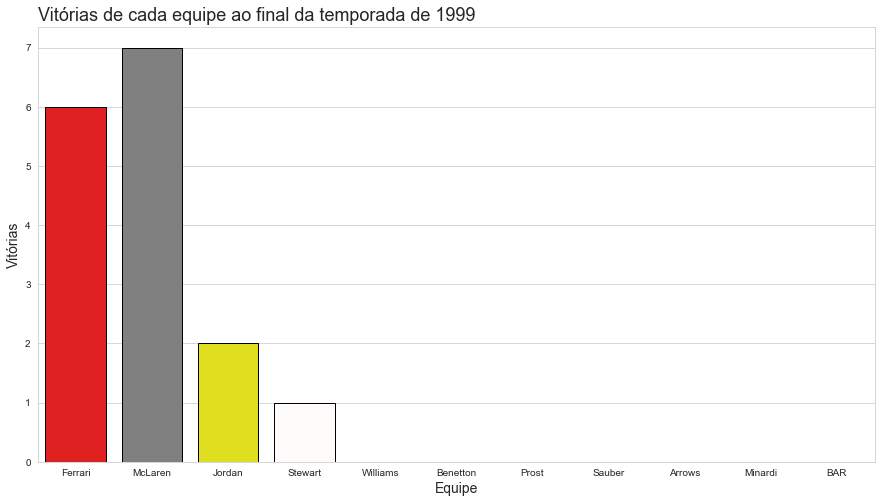

In [131]:
vitorias_1999 = grafico('wins', final_ferrari_1999, 
                      'Vitórias', 'Vitórias de cada equipe ao final da temporada de 1999', paleta)

#### Análise de 1999

No ano de 1999, a Ferrari venceu menos que a McLaren, porém mesmo assim foi campeã. Isso pode indicar que a Ferrari foi mais constante ao longo da temporada. Essa hipótese será confirmada ou desmentida na análise das Médias e do Desvio Padrão.

### 2000

In [133]:
final_ferrari_2000, ferrari_95_05, rival_ferrari = seleciona_pontuacao(2000, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_2000, resultados_rival_ferrari_2000 = resultados_ano(2000, 'Ferrari')
poles_2000, poles_ferrari, rival_poles_ferrari = filtra_pole(2000, poles_ferrari, rival_poles_ferrari, 'Ferrari')

#### Traçando os gráficos de 2000

##### Pontos de cada equipe em 2000

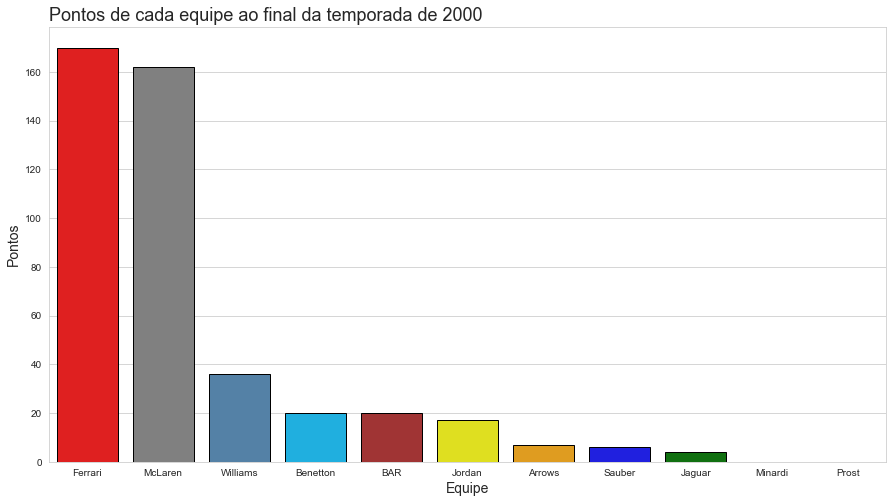

In [134]:
paleta = {'McLaren': 'gray', 'Ferrari': 'red', 'Williams': 'steelblue', 'Jordan': 'yellow', 'Benetton': 'deepskyblue', 'Sauber': 'blue', 'Arrows': 'orange',
         'Jaguar': 'green', 'Prost': 'darkblue', 'Minardi': 'yellowgreen', 'BAR': 'firebrick'}
pontos_2000 = grafico('points', final_ferrari_2000, 
                      'Pontos', 'Pontos de cada equipe ao final da temporada de 2000', paleta)

##### Vitórias de cada equipe em 2000

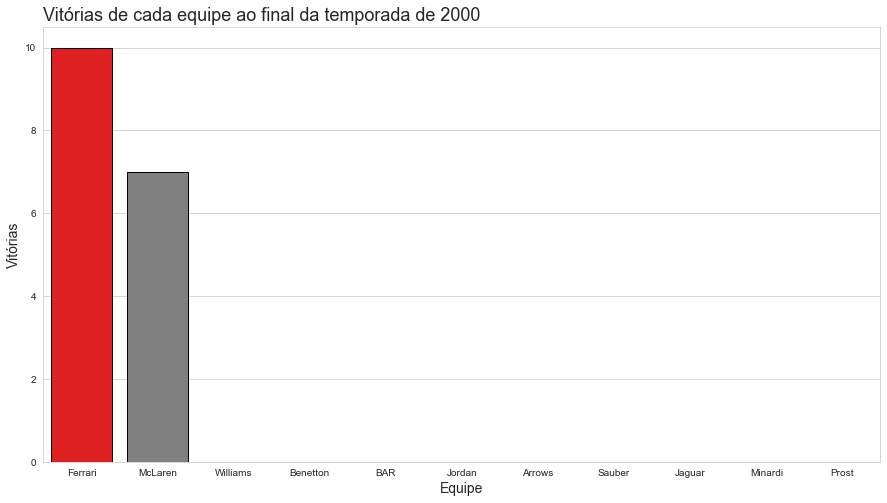

In [135]:
vitorias_2000 = grafico('wins', final_ferrari_2000, 
                        'Vitórias', 'Vitórias de cada equipe ao final da temporada de 2000', paleta)

#### Análise de 2000

No ano de 2000, a Ferrari foi campeã. Ela teve três vitórias a mais que a McLaren porém não venceu por muitos pontos a mais, o que pode indicar uma certa inconstância na pontuação. Essa hipótese será confirmada (ou não) nos gráficos da Média e do Desvio Padrão.

### 2001 a 2005

In [137]:
final_ferrari_2001, ferrari_95_05, rival_ferrari = seleciona_pontuacao(2001, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_2001, resultados_rival_ferrari_2001 = resultados_ano(2001, 'Ferrari')
poles_2001, poles_ferrari, rival_poles_ferrari = filtra_pole(2001, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [138]:
final_ferrari_2002, ferrari_95_05, rival_ferrari = seleciona_pontuacao(2002, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_2002, resultados_rival_ferrari_2002 = resultados_ano(2002, 'Ferrari')
poles_2002, poles_ferrari, rival_poles_ferrari = filtra_pole(2002, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [139]:
final_ferrari_2003, ferrari_95_05, rival_ferrari = seleciona_pontuacao(2003, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_2003, resultados_rival_ferrari_2003 = resultados_ano(2003, 'Ferrari')
poles_2003, poles_ferrari, rival_poles_ferrari = filtra_pole(2003, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [140]:
final_ferrari_2004, ferrari_95_05, rival_ferrari = seleciona_pontuacao(2004, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_2004, resultados_rival_ferrari_2004 = resultados_ano(2004, 'Ferrari')
poles_2004, poles_ferrari, rival_poles_ferrari = filtra_pole(2004, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [141]:
final_ferrari_2005, ferrari_95_05, rival_ferrari = seleciona_pontuacao(2005, 'Ferrari', ferrari_95_05, rival_ferrari)
resultados_ferrari_2005, resultados_rival_ferrari_2005 = resultados_ano(2005, 'Ferrari')
poles_2005, poles_ferrari, rival_poles_ferrari = filtra_pole(2005, poles_ferrari, rival_poles_ferrari, 'Ferrari')

In [142]:
rival_ferrari.rename(columns = {'team_name': 'Nome da Equipe'}, inplace = True)

### <font color=red>Desempenho da Ferrari em cada ano

In [143]:
ferrari_95_05

,year,round,circuitId,name,points,position,wins,team_name,points_per_race,higher_medium,lower_medium,std
3,1992,16,29,Australian Grand Prix,21.0,4,0,Ferrari,1.312500,3.333333,0.125000,1.829250
3,1993,16,29,Australian Grand Prix,28.0,4,0,Ferrari,1.750000,4.166667,0.300000,2.081666
2,1994,16,29,Australian Grand Prix,71.0,3,1,Ferrari,4.437500,6.750000,2.125000,2.874456
2,1995,17,29,Australian Grand Prix,73.0,3,1,Ferrari,4.294118,6.875000,2.000000,3.177356
1,1996,16,22,Japanese Grand Prix,70.0,2,3,Ferrari,4.375000,8.142857,1.444444,3.896580
1,1997,17,26,European Grand Prix,102.0,2,5,Ferrari,6.000000,12.000000,1.500000,5.074446
1,1998,16,22,Japanese Grand Prix,133.0,2,6,Ferrari,8.312500,12.875000,3.750000,5.300550
0,1999,16,22,Japanese Grand Prix,128.0,1,6,Ferrari,8.000000,12.571429,4.000000,4.953113
0,2000,17,2,Malaysian Grand Prix,170.0,1,10,Ferrari,10.000000,14.428571,5.571429,4.387482
0,2001,17,22,Japanese Grand Prix,179.0,1,9,Ferrari,10.529412,14.000000,7.444444,3.938871


### <font color=red>Desempenho das rivais da Ferrari em cada ano

In [144]:
rival_ferrari

,year,round,circuitId,name,points,position,wins,Nome da Equipe,points_per_race,higher_medium,lower_medium,std
0,1992,16,29,Australian Grand Prix,164.0,1,10,Williams,10.250000,16.000000,6.800000,5.744563
0,1993,16,29,Australian Grand Prix,168.0,1,10,Williams,10.500000,14.666667,9.538462,2.338090
0,1994,16,29,Australian Grand Prix,118.0,1,7,Williams,7.375000,11.625000,3.125000,5.149434
0,1995,17,29,Australian Grand Prix,147.0,1,11,Benetton,8.647059,11.727273,3.000000,4.885453
0,1996,16,22,Japanese Grand Prix,175.0,1,12,Williams,10.937500,15.375000,6.500000,5.579352
0,1997,17,26,European Grand Prix,123.0,1,8,Williams,7.235294,10.777778,3.250000,4.507347
0,1998,16,22,Japanese Grand Prix,156.0,1,9,McLaren,9.750000,14.222222,4.000000,5.882176
1,1999,16,22,Japanese Grand Prix,124.0,2,7,McLaren,7.750000,12.250000,3.250000,5.310367
1,2000,17,2,Malaysian Grand Prix,162.0,2,7,McLaren,9.529412,12.909091,3.333333,5.569085
1,2001,17,22,Japanese Grand Prix,102.0,2,4,McLaren,6.000000,9.857143,2.625000,3.952847


### <font color=Red>Analisando anos anteriores, a dominação e um ano após o domínio da Ferrari

#### Pontos por corrida, média alta e média baixa da Ferrari e rivais de 1995 a 2005

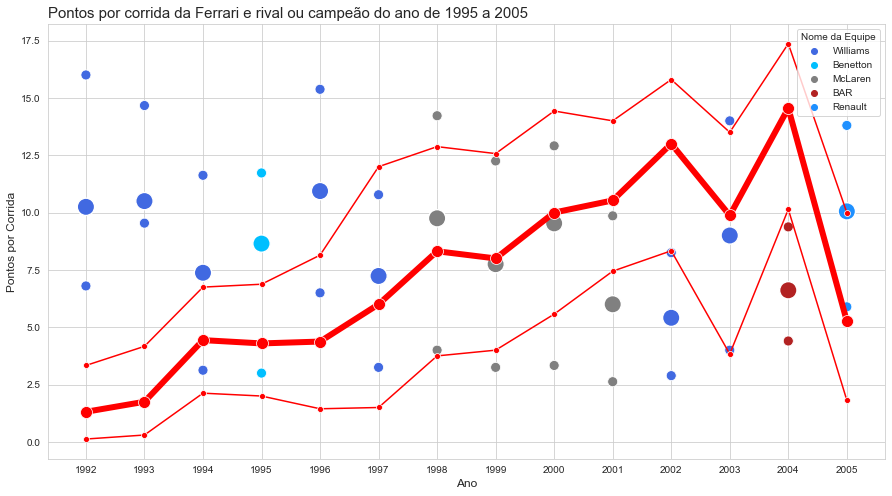

In [145]:
paleta = {'Benetton': 'deepskyblue', 'Williams': 'royalblue', 'McLaren': 'gray', 'BAR': 'firebrick', 'Renault': 'dodgerblue'}
pontos_corrida_ferrari = grafico_comparacao_pontos(ferrari_95_05, rival_ferrari, paleta, 
                                           'Pontos por corrida da Ferrari e rival ou campeão do ano de 1995 a 2005', 
                                           'red')

#### Desvio Padrão da pontuação da Ferrari de 1995 a 2005

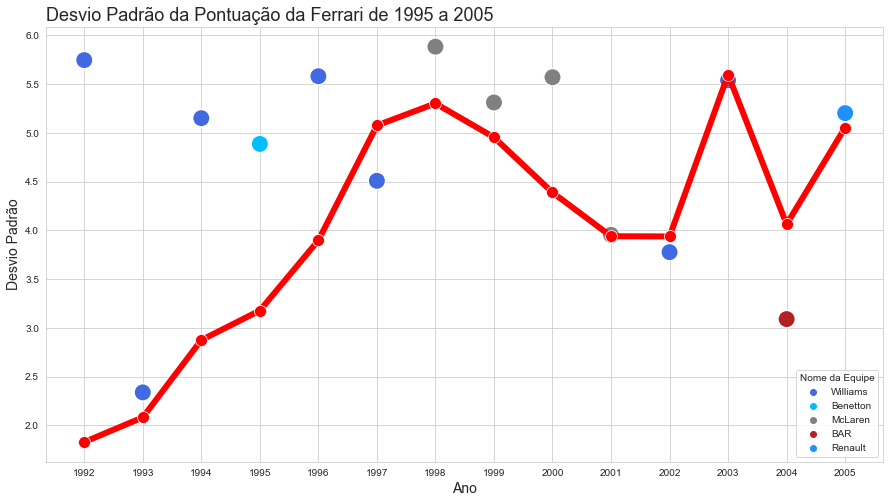

In [146]:
desvio_padrao_ferrari = grafico_comparacao('std', ferrari_95_05, rival_ferrari, paleta, 
                                       'Desvio Padrão da Pontuação da Ferrari de 1995 a 2005', 'Desvio Padrão', 'r')

<!--explicar o porque de analisar 1998, 1999, 2000 e 2003-->
Pelo gráfico das Médias, é possível inferir que a Ferrari teve três de grandes saltos, 1994, 1997 e 2000 (e os outros saltos aproveitaram da "inércia" deles). Nos dois primeiros anos que a Ferrari é campeã (1999 e 2000), ela é mais constante que a McLaren (embora as duas sejam bem inconstantes). 

No entanto, em 1998, apesar de ter um Desvio Padrão maior que a Ferrari, a McLaren ainda é campeã. Ela teve uma Média Baixa parecida com a da Ferrari, porém a Média Geral e a Média Alta são maiores que as da Ferrari. Esse é um ano que merece ser analisado mais de perto.

Já em 1999, as duas equipes têm indicadores muito próximos, com a Ferrari tendo Médias levemente maiores e um Desvio Padrão levemente menor. Esse é um ano que pode ser interessante de se analisar.

No entanto 2000 já foi um ano levemente melhor para a Ferrari. Seu Desvio Padrão decresce bastante. A Média Geral de pontos é relativamente parecida entre as duas equipes, porém Média Baixa e Média Alta são mais altas que as da McLaren. 2000 também é um ano que uma análise pode ser produtiva.

2001 e 2002 foram anos relativamente tranquilos, porém 2003 foi um ano delicado. A Média Geral das duas equipes é relativamente parecida, porém as Médias Alta e Baixa da Williams são maiores que as Médias correspondentes da Ferrari. Também é o ano em que a Ferrari tem o maior Desvio Padrão. 2003 será outro ano analisado mais de perto.

#### Resultados da Ferrari e sua rival em 1998

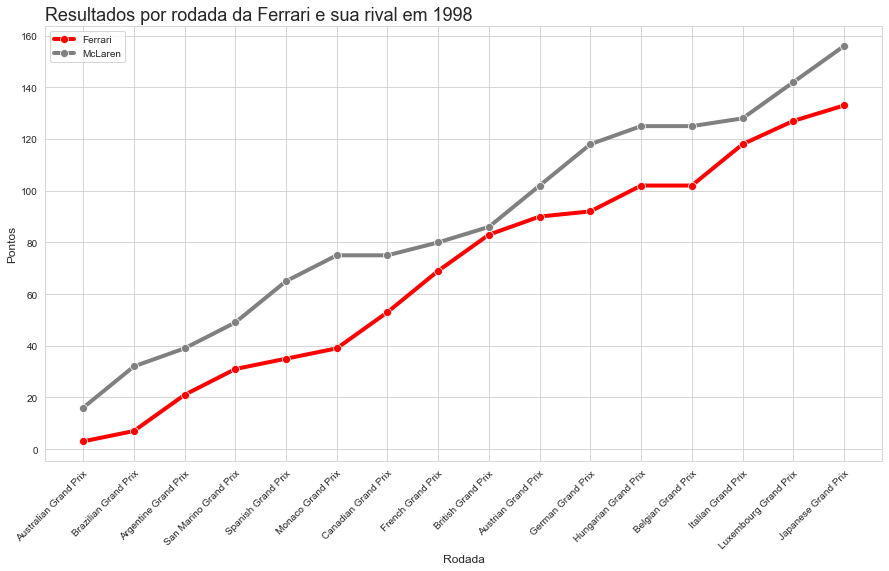

In [148]:
results_ferrari_98 = grafico_evolucao_pontuacao(resultados_ferrari_1998, resultados_rival_ferrari_1998, 'r', 'grey', 
                                                  'Resultados por rodada da Ferrari e sua rival em 1998')

No ano de 1998, a McLaren performou muito bem durante o ano, sempre à frente da Ferrari. Houveram períodos em que a Ferrari se saiu muito melhor que a McLaren, principalmente do GP do Canadá até o GP Britânico, período em que ela quase passou a McLaren no campeonato de construtores. Ambas as curvas das equipes parecem mais "ondas", porém a onda da McLaren é mais alta e tem pontos mais baixos (comparando com seus pontos altos).

#### Resultados da Ferrari e sua rival em 1999

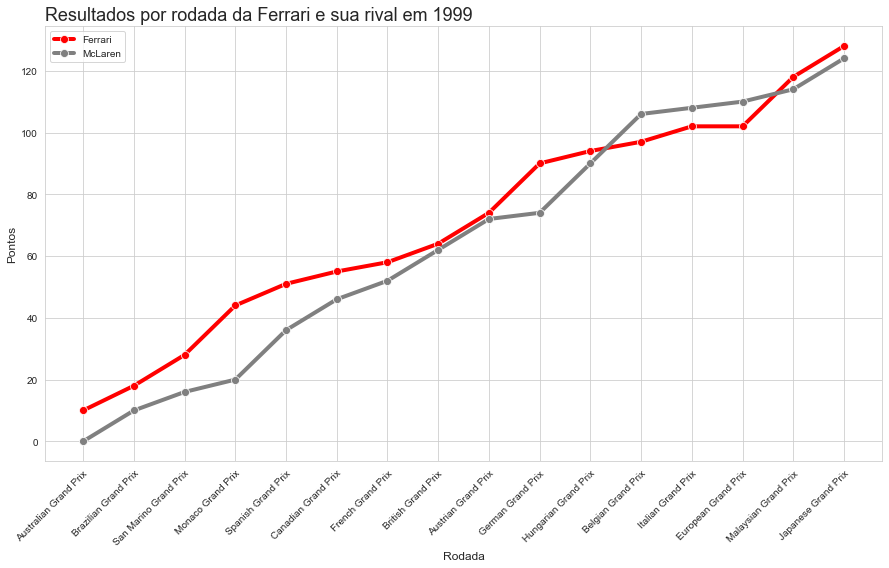

In [150]:
results_ferrari_99 = grafico_evolucao_pontuacao(resultados_ferrari_1999, resultados_rival_ferrari_1999, 'r', 'grey', 
                                                  'Resultados por rodada da Ferrari e sua rival em 1999')

Em 1999, as equipes tiveram um ano extremamente parecido, com pontos altos e pontos baixos. A Ferrari ficou a maior parte da temporada na frente, mas assumiu a frente do campeonato no GP da Bélgica, após duas ótimas corridas. Mas, depois de assumir, ela teve maus resultados, o que permitiu que a Ferrari se recuperasse e ganhasse o campeonato.

#### Resultados da Ferrari e sua rival em 2000

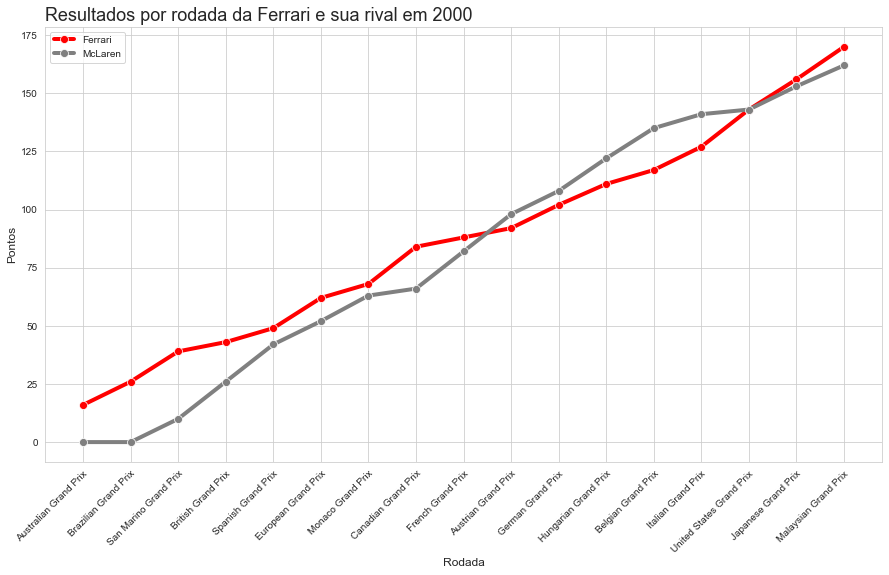

In [152]:
results_ferrari_00 = grafico_evolucao_pontuacao(resultados_ferrari_2000, resultados_rival_ferrari_2000, 'r', 'grey', 
                                                  'Resultados por rodada da Ferrari e sua rival em 2000')

Em 2000, a Ferrari também passou a maior parte da temporada na frente, mas na segunda metade a McLaren assumiu a frente, mas como na temporada anterior, a McLaren teve maus resultados, o que permitiu que a Ferrari assumisse a frente do campeonato nas duas últimas corridas.
A Ferrari também foi mais constante que a McLaren, sua curva é muito mais "reta" do que a curva da McLaren.

#### Resultados da Ferrari e sua rival em 2003

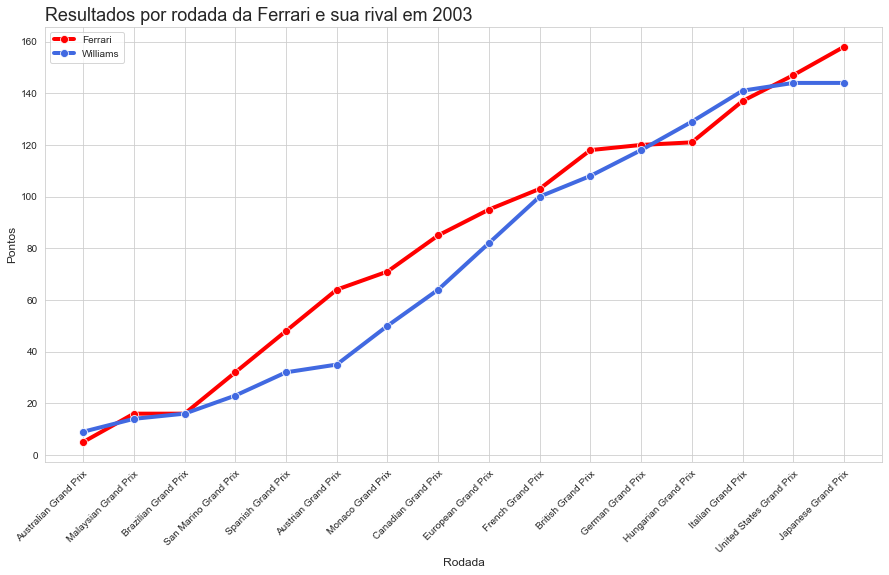

In [113]:
results_ferrari_03 = grafico_evolucao_pontuacao(resultados_ferrari_2003, resultados_rival_ferrari_2003, 'r', 'royalblue', 
                                                  'Resultados por rodada da Ferrari e sua rival em 2003')

Assim como nas temporadas anteriores, a Ferrari passou a maior parte da temporada na frente, porém após bons resultados da Williams e alguns maus resultados da Ferrari, a Williams assumiu a liderança do campeonato de construtores, mas como nas temporadas anteriores, ela teve maus resultados ao mesmo tempo que a Ferrari teve ótimos resultados, o que permitiu que a Ferrari pegasse mais uma vez o campeonato de construtores.

#### Posição da Ferrari no campeonato de construtores de 1995 a 2005

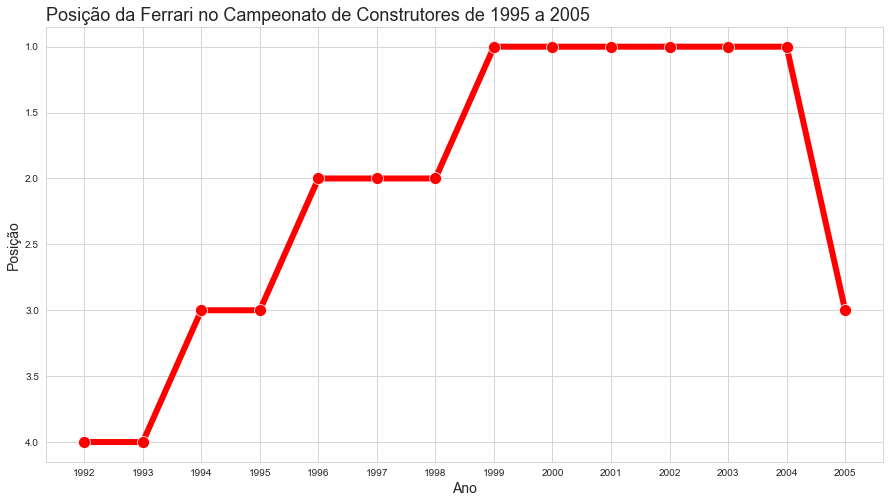

In [154]:
posicao_ferrari = grafico_posicao('position', ferrari_95_05, 
                                  'Posição da Ferrari no Campeonato de Construtores de 1995 a 2005', 
                                  'Posição', 'r')

#### Vitórias da Ferrari e sua rival de 1995 a 2005

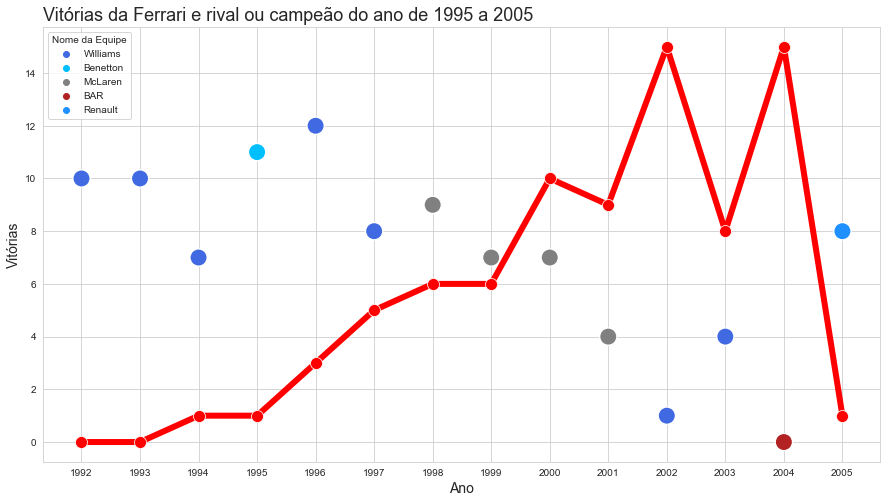

In [155]:
vitorias_ferrari = grafico_comparacao('wins', ferrari_95_05, rival_ferrari, paleta, 
                                     'Vitórias da Ferrari e rival ou campeão do ano de 1995 a 2005', 
                                      'Vitórias', 'red')

### <font color=RED>Conclusão

Com a Ferrari acontece um caso atípico. Ela teve crescimento em anos anteriores, e em 1998 cresceu bastante também, tanto que ela ficou perto da McLaren na luta pelo título, mas o crescimento da Ferrari aconteceu ao longo de muitos anos, não houve uma grande explosão no ano anterior ao título. Ela ficou muito bem sim, teve mais vitórias, mais pontos por corrida, porém não hoube algo grande como visto na Red Bull e na Mercedes.

Como a Ferrari é um caso atípico, ela não contribuirá nem desmentirá a hipótese dos Indicadores.

<!--analise-->

<h2>Conclusão Geral</h2>

Das 3 equipes, somente duas confirmam a hipótese e uma delas traz inconclusividade. Acredito que seja possível aceitar a hipótese, mas esse é somente um treino. Existem muitos fatores que podem levar uma equipe a decair ou a dominar, não somente uma "inércia" de anos anteriores. Mudanças de regulamento, pilotos, acontecimentos internos na equipe. Muitas coisas influenciam, logo, este estudo não deve ser levado tão a sério. 

Porém, é possível perceber sim um aumento nos Indicadores (número de poles, vitórias, pontos por corrida, desvio padrão, etc). Logo, apesar de haver poucos dados para comprovar (afinal, somente três dominações foram analisadas), há Indicadores que uma dominância pode vir a acontecer nos próximos anos.